In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm

import os
import datetime

start_time = datetime.datetime.now() 
print(start_time)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

2024-06-17 03:08:24.356239


# Ensure you have a graphics card, otherwise the training time will be excessively long

In [2]:
device = torch.device("cuda:0")
print(torch.cuda.is_available())

True


# Set fixed random seed to ensure reproducible results

In [3]:
def set_seed(seed):
    # --- Set random seed
    random.seed(seed)
    np.random.seed(seed)
    # --- Ensure consistency in hash behavior
    os.environ["PYTHONHASHSEED"] = str(seed)
    # --- Setting the workspace configuration of cuBLAS
    """
    By setting the workspace configuration of cuBLAS, 
    specific workspace sizes and algorithm combinations are ensured when running deep learning models, 
    thereby maintaining consistency of results.
    """
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # --- Make the random numbers generated on the CPU repeatable
    torch.manual_seed(seed)
    # --- Make the random numbers generated on a single GPU repeatable
    torch.cuda.manual_seed(seed)
    # --- Make the random numbers generated on multiple GPUs repeatable
    torch.cuda.manual_seed_all(seed)
    # --- Using deterministic algorithms ensures consistency and repeatability of calculation results across different runs
    torch.use_deterministic_algorithms(True)
    # --- Set the cuDNN backend to deterministic mode to ensure the use of deterministic algorithms
    """
    Certain operations (such as convolution) produce the same result in multiple runs.
    """
    torch.backends.cudnn.deterministic = True
    # --- Disable cuDNN using non deterministic algorithms
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False

set_seed(2024)

# Define a function for calculating accuracy

In [4]:
def get_clean_acc(model, data_loader, model_device):
    model.eval()
    correct = 0
    total = 0
    
    for data, labels in data_loader:
        data, labels = data.to(model_device), labels.to(model_device)
        with torch.no_grad():
            logits = model(data)
            prediction = torch.argmax(logits, 1)
            ground_truth = labels
            total += labels.size(0)
            correct += (prediction == ground_truth).sum().item()
            
    accuracy = correct / total
    print(f"Total:{total}  Correct:{correct}  CleanAccuracy:{accuracy:.4f}")
    return accuracy

# Define a function for training the model

In [5]:
def train(model_device,
          model,
          model_optimizer, 
          train_set, validate_set,
          epochs=200,
          classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
         ):
    train_loss_list = []
    validate_loss_list = []
    best_acc = -np.Inf
    
    # --- Define Scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=model_optimizer, milestones=[60, 120, 180], last_epoch=0 - 1)
    
    # --- Train
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        validate_loss = 0.0
        model.train()
        count = 0
        for dataset_train, dataset_train_labels in train_set:
            count = count + 1
            dataset_train, dataset_train_labels = dataset_train.to(model_device), dataset_train_labels.to(model_device)
            
            logits = model(dataset_train)

            model_optimizer.zero_grad()
            loss = nn.CrossEntropyLoss(reduction="mean")(logits, dataset_train_labels)
            loss.backward()
            model_optimizer.step()
            
            train_loss += loss.item()
            torch.cuda.empty_cache()
        train_loss_list.append(train_loss / count)
        if scheduler is not None:
            scheduler.step()
        
        # --- Validate
        model.eval()
        count = 0
        for dataset_validate, dataset_validate_labels in validate_set:
            count = count + 1
            dataset_validate, dataset_validate_labels = dataset_validate.to(model_device), dataset_validate_labels.to(model_device)

            with torch.no_grad():
                logits = model(dataset_validate)
            loss = nn.CrossEntropyLoss(reduction="mean")(logits, dataset_validate_labels)

            validate_loss += loss.item()
            torch.cuda.empty_cache()
        validate_loss_list.append(validate_loss / count)
        
        # --- Show results
        model.eval()
        end_time = datetime.datetime.now()
        time = end_time - start_time
        print(f"Epoch:{epoch}\nTime:{time}\nLoss:{validate_loss / count}")           
        acc = get_clean_acc(model, validate_set, model_device)
        torch.cuda.empty_cache()
        
        # --- Save best model parameters
        if not os.path.exists("./best_params/mnist/wrn_28_10"):
            os.makedirs("./best_params/mnist/wrn_28_10")
        if acc >= best_acc:
            path = os.path.join("./best_params/mnist/wrn_28_10", f"wrn_28_10_params_{epoch}.pth")
            #torch.save(model.module.state_dict(), path)   # Enable during multi-GPUs training
            torch.save(model.state_dict(), path)           # Enable during single GPU training
            best_acc = acc
       
        # --- Visualize loss
        if epoch != 0:
            fig = plt.figure(figsize=(5, 5))
            x = range(0, len(validate_loss_list))
            y1 = train_loss_list
            y2 = validate_loss_list
            plt.plot(x, y1, label="Train Loss")
            plt.plot(x, y2, label="Validate Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            if not os.path.exists("./best_params/mnist/wrn_28_10/loss_curve"):
                os.makedirs("./best_params/mnist/wrn_28_10/loss_curve")
            path = os.path.join("./best_params/mnist/wrn_28_10/loss_curve", f"loss_curve_{epoch}.png")
            plt.savefig(path, bbox_inches='tight', dpi=500)
            plt.show()

# Load the dataset

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4, padding_mode="edge"),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="./data",
                                       train=True,
                                       transform=transform_train,
                                       download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)

test_set = torchvision.datasets.MNIST(root="./data",
                                      train=False,
                                      transform=transform_test,
                                      download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=1)
 
print("size=", len(train_loader))
print("size=", len(test_loader))

size= 1875
size= 313


# Load the model

In [7]:
from model_zoo.wide_resnet import wideresnet_28_10_mnist
net = wideresnet_28_10_mnist()
net = net.to(device)

# Define Optimizer

In [8]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Begin to train

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch:0
Time:0:04:38.686778
Loss:0.07628859397427093


  0%|▍                                                                             | 1/200 [04:51<16:06:04, 291.28s/it]

Total:10000  Correct:9774  CleanAccuracy:0.9774
Epoch:1
Time:0:09:03.601790
Loss:0.2083158766993652
Total:10000  Correct:9336  CleanAccuracy:0.9336


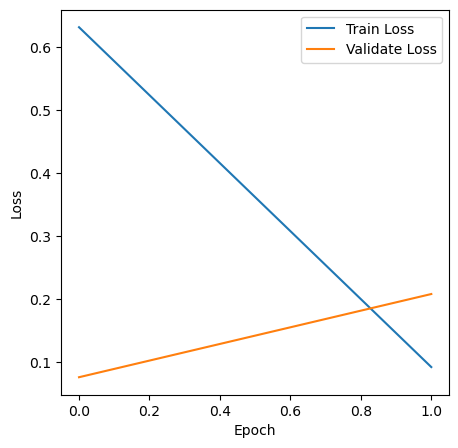

  1%|▊                                                                             | 2/200 [09:16<15:11:22, 276.17s/it]

Epoch:2
Time:0:13:28.817985
Loss:0.06031249744944816
Total:10000  Correct:9818  CleanAccuracy:0.9818


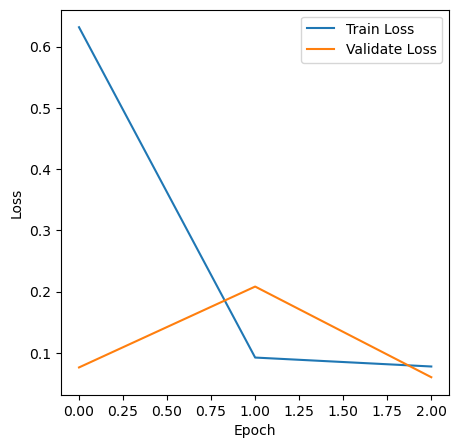

  2%|█▏                                                                            | 3/200 [13:42<14:50:37, 271.25s/it]

Epoch:3
Time:0:17:58.305159
Loss:0.059008327254001944
Total:10000  Correct:9835  CleanAccuracy:0.9835


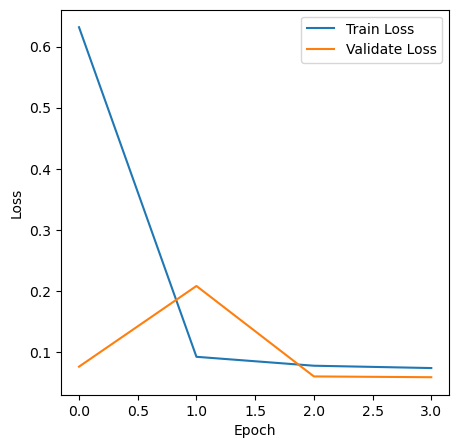

  2%|█▌                                                                            | 4/200 [18:11<14:43:51, 270.57s/it]

Epoch:4
Time:0:22:24.778593
Loss:0.07821853297387664
Total:10000  Correct:9765  CleanAccuracy:0.9765


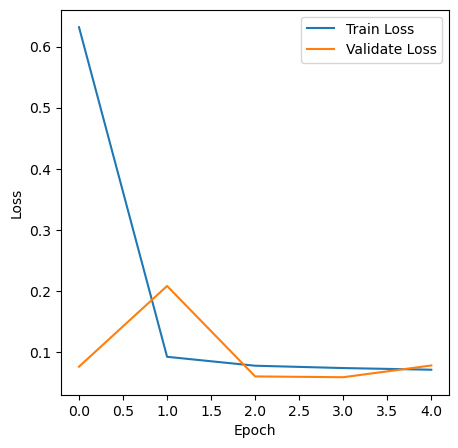

  2%|█▉                                                                            | 5/200 [22:38<14:34:18, 269.02s/it]

Epoch:5
Time:0:26:50.046196
Loss:0.09678377393043984
Total:10000  Correct:9737  CleanAccuracy:0.9737


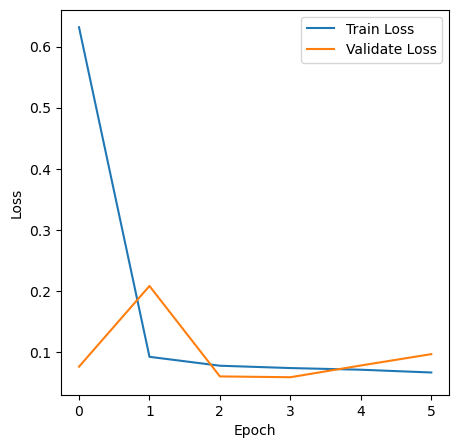

  3%|██▎                                                                           | 6/200 [27:02<14:24:29, 267.37s/it]

Epoch:6
Time:0:31:23.579687
Loss:0.10325640237060027
Total:10000  Correct:9676  CleanAccuracy:0.9676


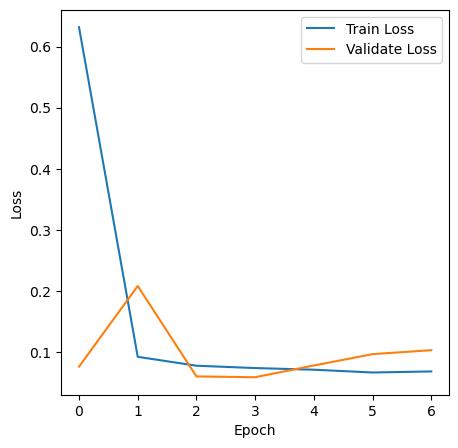

  4%|██▋                                                                           | 7/200 [31:36<14:27:41, 269.75s/it]

Epoch:7
Time:0:35:49.446554
Loss:0.06220322902115008
Total:10000  Correct:9836  CleanAccuracy:0.9836


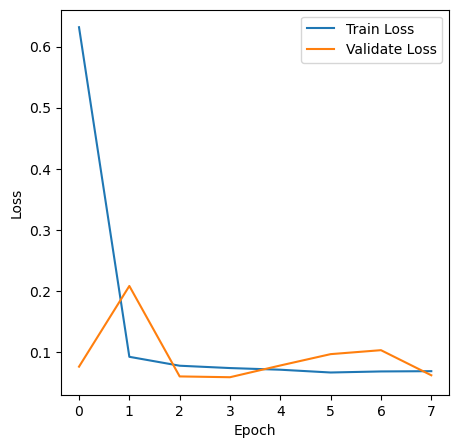

  4%|███                                                                           | 8/200 [36:02<14:19:18, 268.53s/it]

Epoch:8
Time:0:40:14.192197
Loss:0.0436544106248915
Total:10000  Correct:9858  CleanAccuracy:0.9858


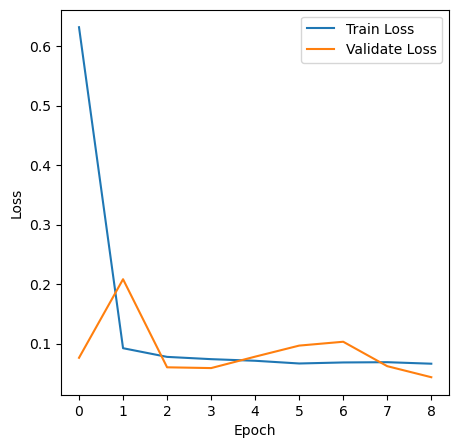

  4%|███▌                                                                          | 9/200 [40:27<14:10:33, 267.19s/it]

Epoch:9
Time:0:44:39.424772
Loss:0.03555473714996056
Total:10000  Correct:9886  CleanAccuracy:0.9886


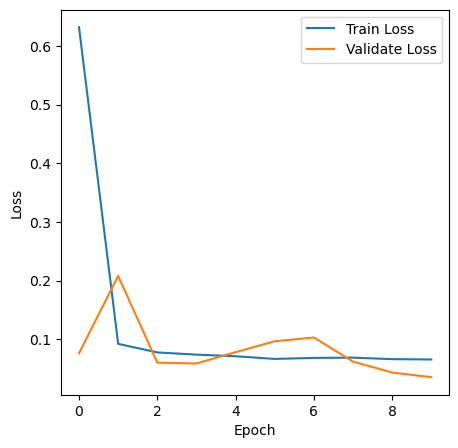

  5%|███▊                                                                         | 10/200 [44:52<14:04:31, 266.69s/it]

Epoch:10
Time:0:49:04.929083
Loss:0.05090982645445804
Total:10000  Correct:9855  CleanAccuracy:0.9855


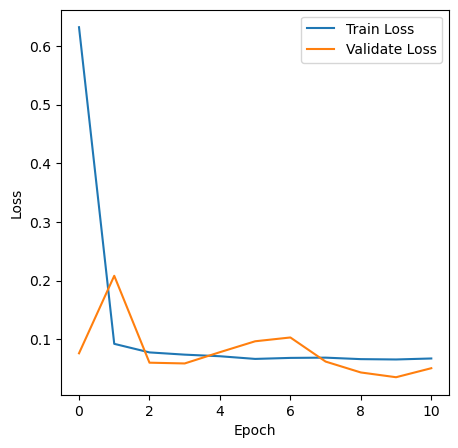

  6%|████▏                                                                        | 11/200 [49:18<13:58:55, 266.32s/it]

Epoch:11
Time:0:53:29.937612
Loss:0.048325804484890586
Total:10000  Correct:9873  CleanAccuracy:0.9873


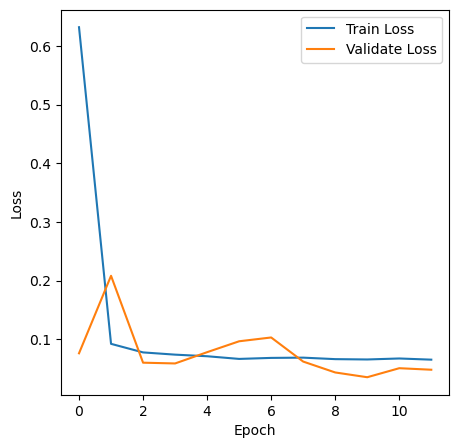

  6%|████▌                                                                        | 12/200 [53:42<13:53:06, 265.88s/it]

Epoch:12
Time:0:57:55.185889
Loss:0.03532450317414276
Total:10000  Correct:9894  CleanAccuracy:0.9894


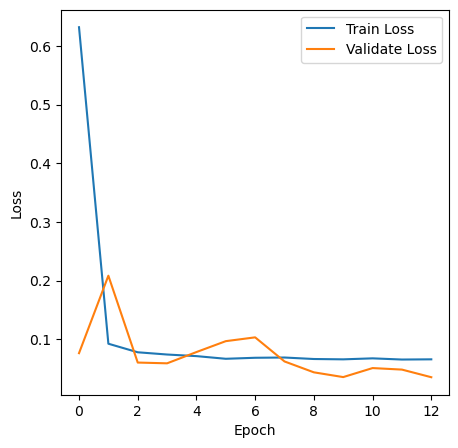

  6%|█████                                                                        | 13/200 [58:08<13:48:20, 265.78s/it]

Epoch:13
Time:1:02:20.742834
Loss:0.05343624260610367
Total:10000  Correct:9824  CleanAccuracy:0.9824


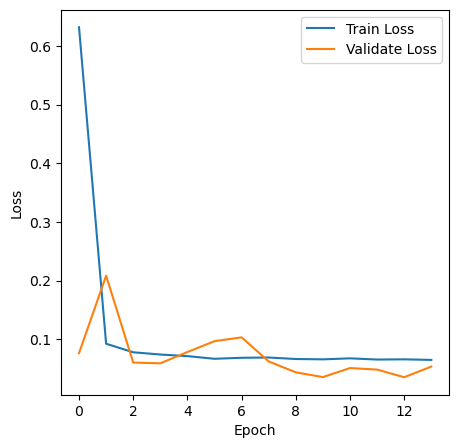

  7%|█████▎                                                                     | 14/200 [1:02:33<13:43:08, 265.53s/it]

Epoch:14
Time:1:06:51.930660
Loss:0.04655624789476581
Total:10000  Correct:9857  CleanAccuracy:0.9857


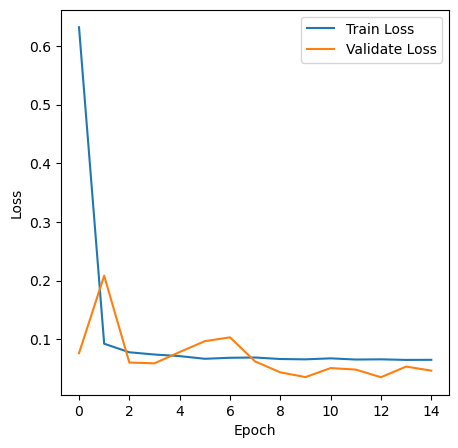

  8%|█████▋                                                                     | 15/200 [1:07:06<13:46:02, 267.91s/it]

Epoch:15
Time:1:11:45.392556
Loss:0.05070225427051063
Total:10000  Correct:9840  CleanAccuracy:0.9840


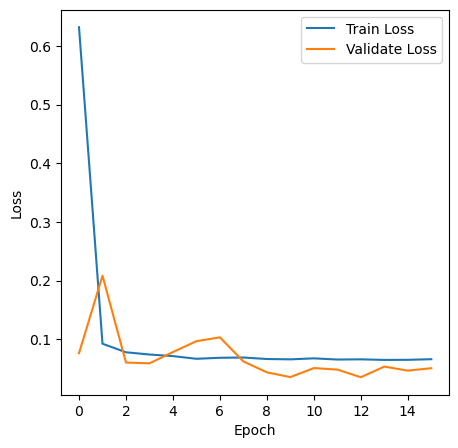

  8%|██████                                                                     | 16/200 [1:11:58<14:03:38, 275.10s/it]

Epoch:16
Time:1:17:22.183713
Loss:0.08357243839232549
Total:10000  Correct:9739  CleanAccuracy:0.9739


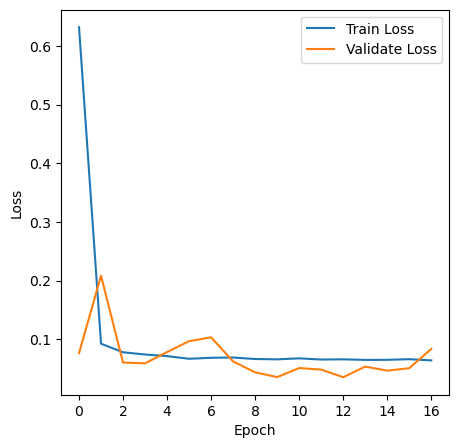

  8%|██████▍                                                                    | 17/200 [1:17:35<14:55:53, 293.73s/it]

Epoch:17
Time:1:23:13.571759
Loss:0.10007696561890984
Total:10000  Correct:9657  CleanAccuracy:0.9657


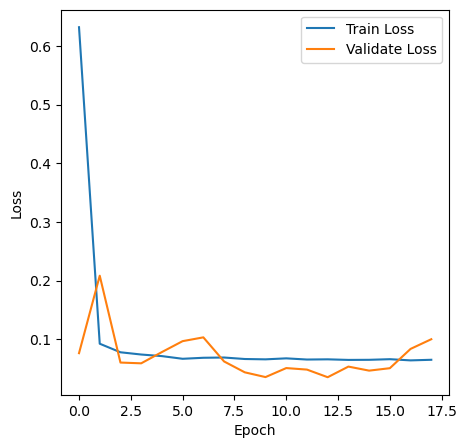

  9%|██████▊                                                                    | 18/200 [1:23:28<15:44:43, 311.45s/it]

Epoch:18
Time:1:29:11.081436
Loss:0.0749515780410841
Total:10000  Correct:9763  CleanAccuracy:0.9763


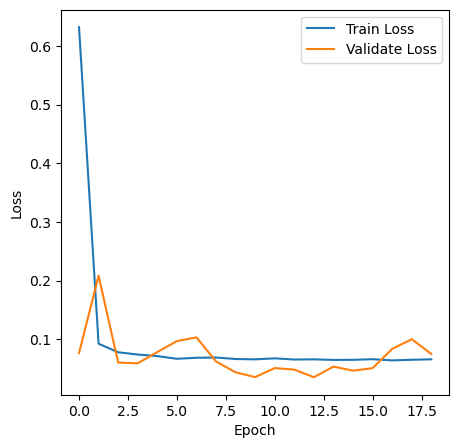

 10%|███████▏                                                                   | 19/200 [1:29:26<16:21:38, 325.41s/it]

Epoch:19
Time:1:34:58.530040
Loss:0.0632965164310217
Total:10000  Correct:9792  CleanAccuracy:0.9792


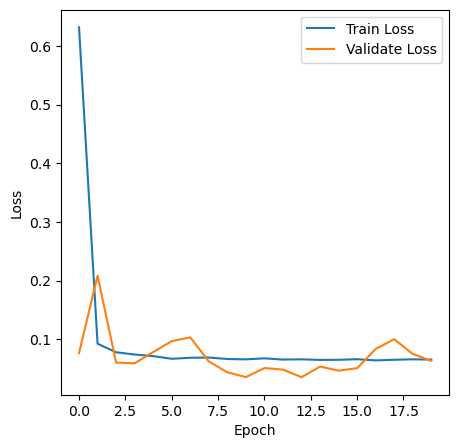

 10%|███████▌                                                                   | 20/200 [1:35:13<16:35:41, 331.90s/it]

Epoch:20
Time:1:40:57.480254
Loss:0.09296821263327171
Total:10000  Correct:9754  CleanAccuracy:0.9754


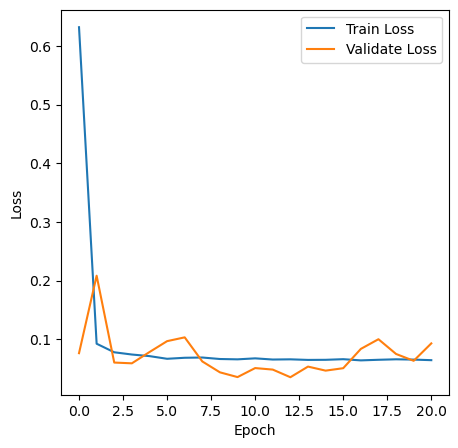

 10%|███████▉                                                                   | 21/200 [1:41:12<16:54:40, 340.11s/it]

Epoch:21
Time:1:46:54.581757
Loss:0.07299837798779137
Total:10000  Correct:9776  CleanAccuracy:0.9776


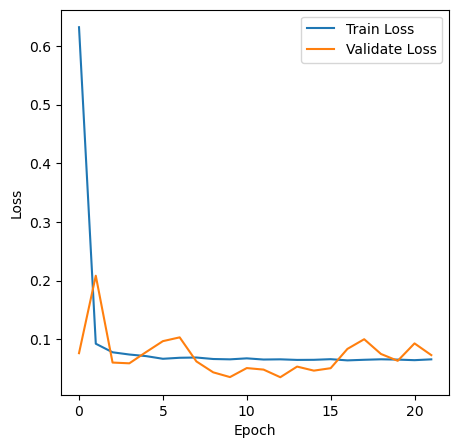

 11%|████████▎                                                                  | 22/200 [1:47:09<17:04:02, 345.18s/it]

Epoch:22
Time:1:52:46.976923
Loss:0.15024372943849584
Total:10000  Correct:9532  CleanAccuracy:0.9532


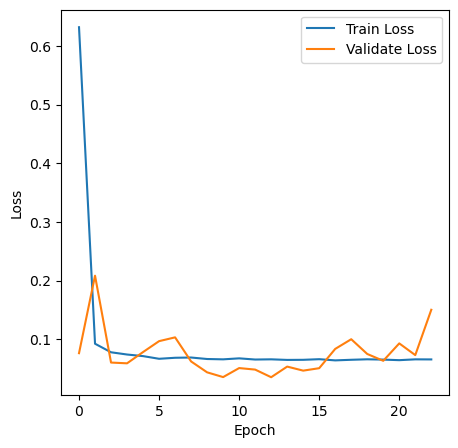

 12%|████████▋                                                                  | 23/200 [1:53:01<17:04:10, 347.18s/it]

Epoch:23
Time:1:58:23.662518
Loss:0.10450975861070833
Total:10000  Correct:9691  CleanAccuracy:0.9691


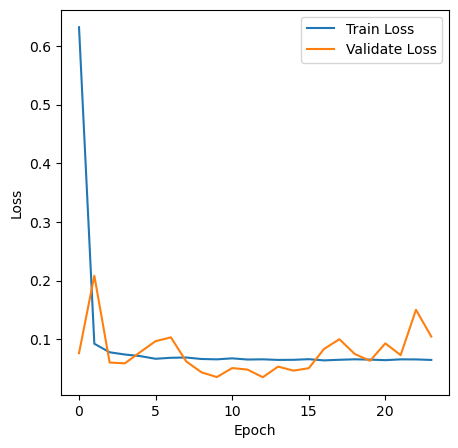

 12%|█████████                                                                  | 24/200 [1:58:38<16:49:22, 344.10s/it]

Epoch:24
Time:2:03:34.468394
Loss:0.0658640937354139
Total:10000  Correct:9794  CleanAccuracy:0.9794


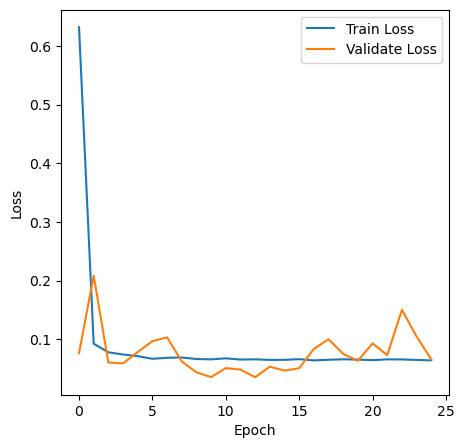

 12%|█████████▍                                                                 | 25/200 [2:03:48<16:13:42, 333.84s/it]

Epoch:25
Time:2:08:22.001549
Loss:0.16998214984996826
Total:10000  Correct:9515  CleanAccuracy:0.9515


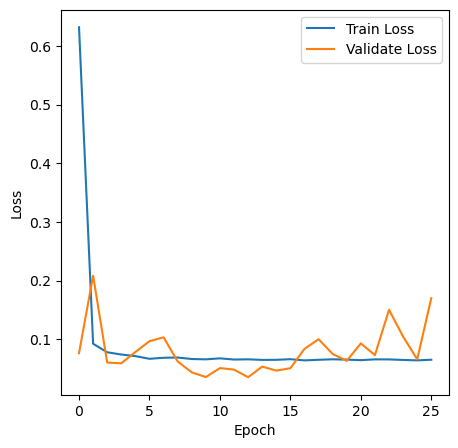

 13%|█████████▊                                                                 | 26/200 [2:08:36<15:28:41, 320.24s/it]

Epoch:26
Time:2:13:15.736827
Loss:0.08700331892206753
Total:10000  Correct:9745  CleanAccuracy:0.9745


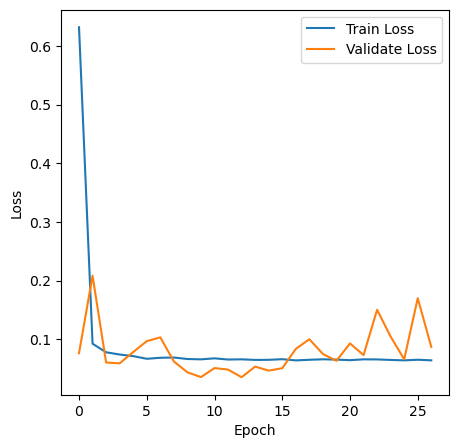

 14%|██████████▏                                                                | 27/200 [2:13:29<14:59:52, 312.09s/it]

Epoch:27
Time:2:18:51.831760
Loss:0.06207877238349507
Total:10000  Correct:9820  CleanAccuracy:0.9820


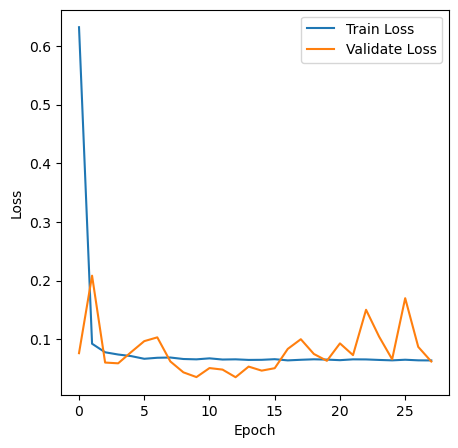

 14%|██████████▌                                                                | 28/200 [2:19:06<15:15:32, 319.38s/it]

Epoch:28
Time:2:24:04.401576
Loss:0.14308004434884022
Total:10000  Correct:9542  CleanAccuracy:0.9542


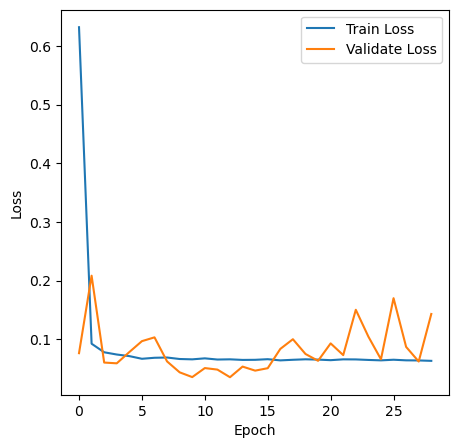

 14%|██████████▉                                                                | 29/200 [2:24:17<15:03:28, 317.01s/it]

Epoch:29
Time:2:29:07.521444
Loss:0.08094043104787366
Total:10000  Correct:9743  CleanAccuracy:0.9743


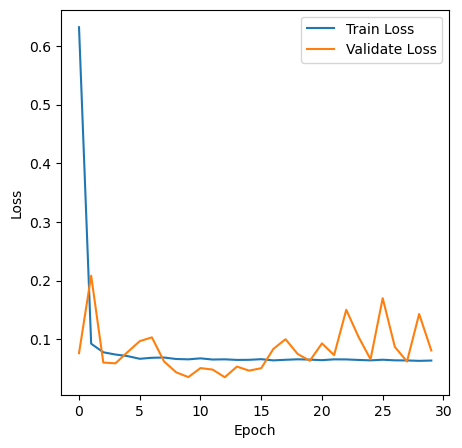

 15%|███████████▎                                                               | 30/200 [2:29:20<14:45:48, 312.64s/it]

Epoch:30
Time:2:34:06.910126
Loss:0.1709982831025133
Total:10000  Correct:9493  CleanAccuracy:0.9493


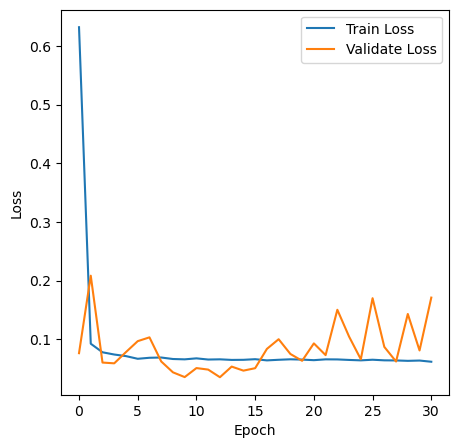

 16%|███████████▋                                                               | 31/200 [2:34:20<14:29:52, 308.83s/it]

Epoch:31
Time:2:38:51.710988
Loss:0.48963643241518984
Total:10000  Correct:8448  CleanAccuracy:0.8448


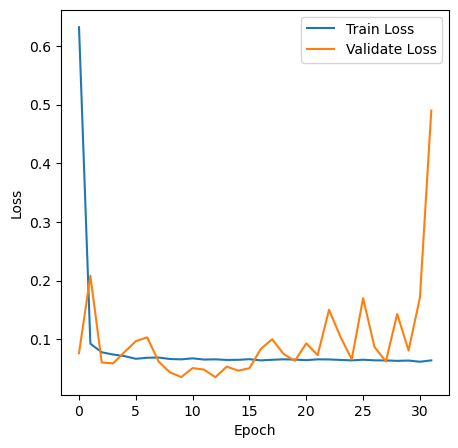

 16%|████████████                                                               | 32/200 [2:39:04<14:04:14, 301.52s/it]

Epoch:32
Time:2:43:54.233299
Loss:0.05549831840441378
Total:10000  Correct:9835  CleanAccuracy:0.9835


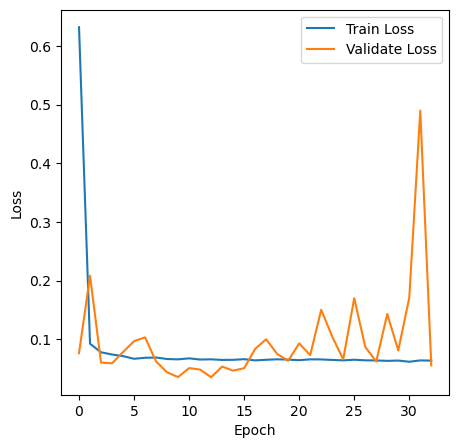

 16%|████████████▍                                                              | 33/200 [2:44:09<14:01:37, 302.38s/it]

Epoch:33
Time:2:49:54.947395
Loss:0.13796569080465435
Total:10000  Correct:9579  CleanAccuracy:0.9579


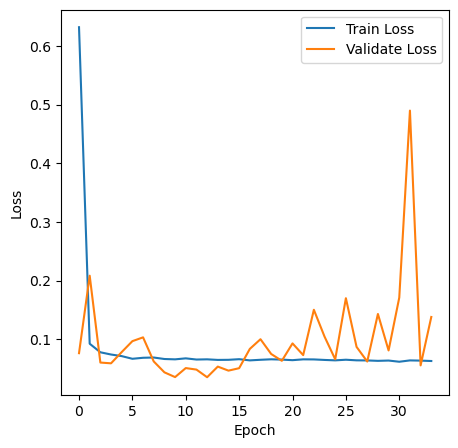

 17%|████████████▊                                                              | 34/200 [2:50:08<14:44:16, 319.62s/it]

Epoch:34
Time:2:54:40.181673
Loss:0.04117589523627485
Total:10000  Correct:9878  CleanAccuracy:0.9878


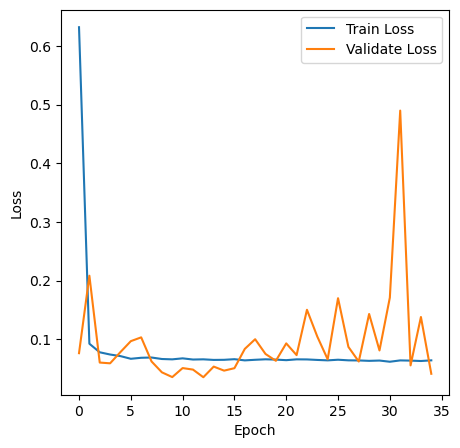

 18%|█████████████▏                                                             | 35/200 [2:54:55<14:12:05, 309.85s/it]

Epoch:35
Time:3:00:39.351692
Loss:0.1108513484432246
Total:10000  Correct:9654  CleanAccuracy:0.9654


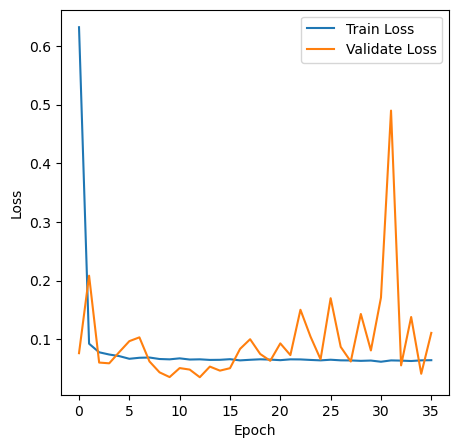

 18%|█████████████▌                                                             | 36/200 [3:00:54<14:47:05, 324.54s/it]

Epoch:36
Time:3:06:38.165095
Loss:0.05517983077463661
Total:10000  Correct:9838  CleanAccuracy:0.9838


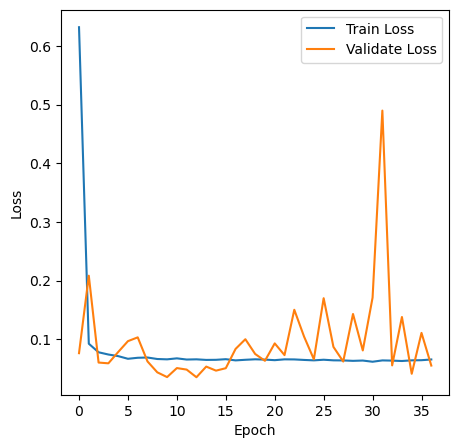

 18%|█████████████▉                                                             | 37/200 [3:06:53<15:09:48, 334.90s/it]

Epoch:37
Time:3:12:22.680038
Loss:0.052084055695759565
Total:10000  Correct:9851  CleanAccuracy:0.9851


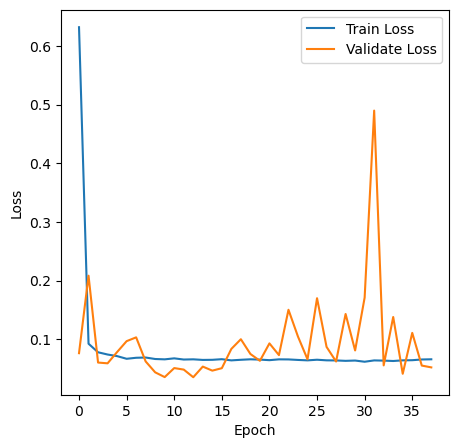

 19%|██████████████▎                                                            | 38/200 [3:12:37<15:11:29, 337.59s/it]

Epoch:38
Time:3:17:22.540381
Loss:0.04726773047622237
Total:10000  Correct:9863  CleanAccuracy:0.9863


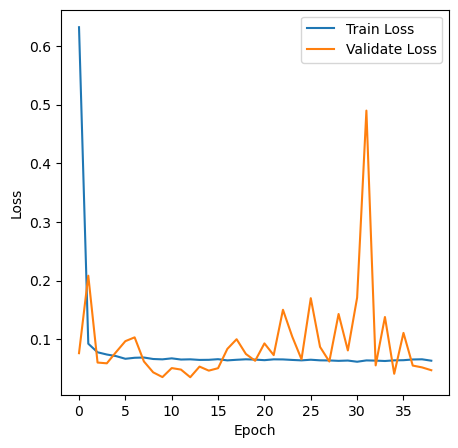

 20%|██████████████▋                                                            | 39/200 [3:17:38<14:36:39, 326.71s/it]

Epoch:39
Time:3:22:05.594547
Loss:0.05632396558414588
Total:10000  Correct:9817  CleanAccuracy:0.9817


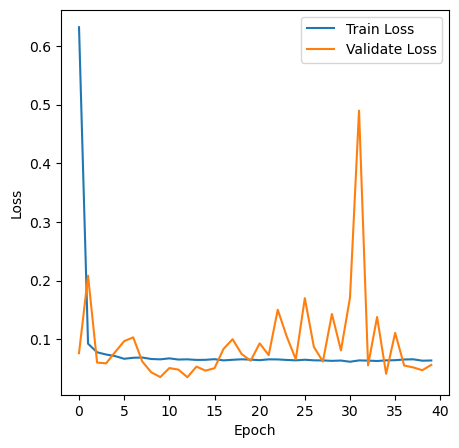

 20%|███████████████                                                            | 40/200 [3:22:18<13:53:50, 312.69s/it]

Epoch:40
Time:3:26:52.031102
Loss:0.045893706306887674
Total:10000  Correct:9852  CleanAccuracy:0.9852


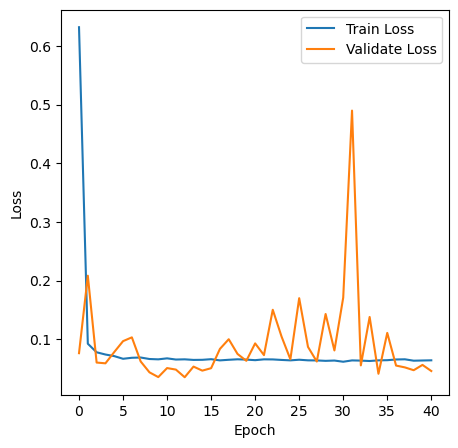

 20%|███████████████▎                                                           | 41/200 [3:27:05<13:28:02, 304.92s/it]

Epoch:41
Time:3:31:51.742541
Loss:0.055382961691461334
Total:10000  Correct:9837  CleanAccuracy:0.9837


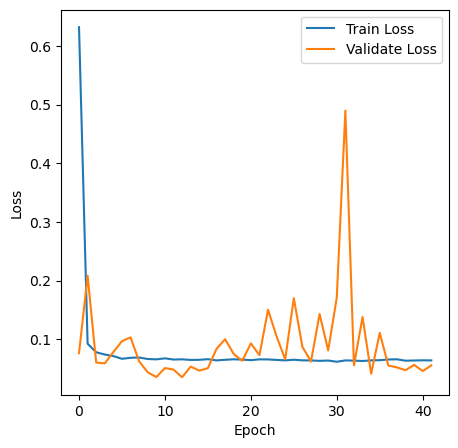

 21%|███████████████▊                                                           | 42/200 [3:32:06<13:19:41, 303.68s/it]

Epoch:42
Time:3:37:14.117361
Loss:0.060477001429609836
Total:10000  Correct:9819  CleanAccuracy:0.9819


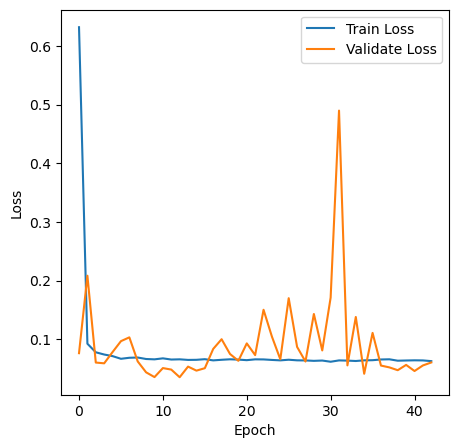

 22%|████████████████▏                                                          | 43/200 [3:37:29<13:30:00, 309.56s/it]

Epoch:43
Time:3:42:45.262056
Loss:0.045431351170785124
Total:10000  Correct:9848  CleanAccuracy:0.9848


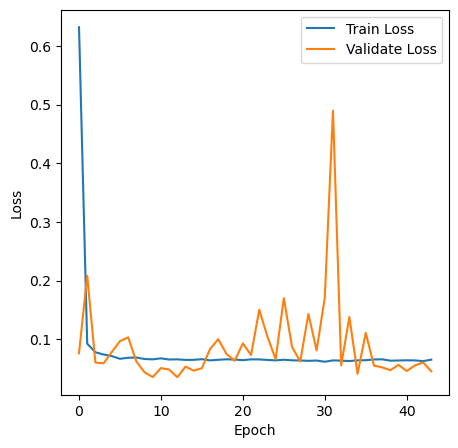

 22%|████████████████▌                                                          | 44/200 [3:43:00<13:40:58, 315.76s/it]

Epoch:44
Time:3:47:51.652822
Loss:0.23848822210043574
Total:10000  Correct:9226  CleanAccuracy:0.9226


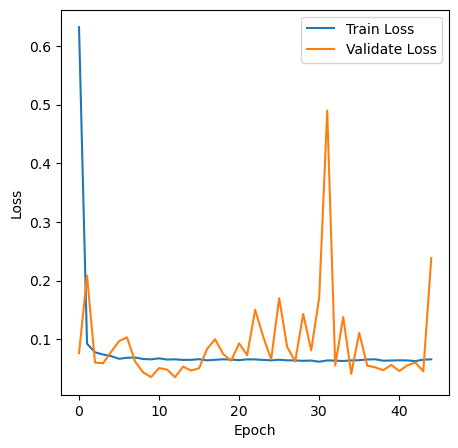

 22%|████████████████▉                                                          | 45/200 [3:48:04<13:27:11, 312.46s/it]

Epoch:45
Time:3:52:31.045487
Loss:0.07075391558018296
Total:10000  Correct:9790  CleanAccuracy:0.9790


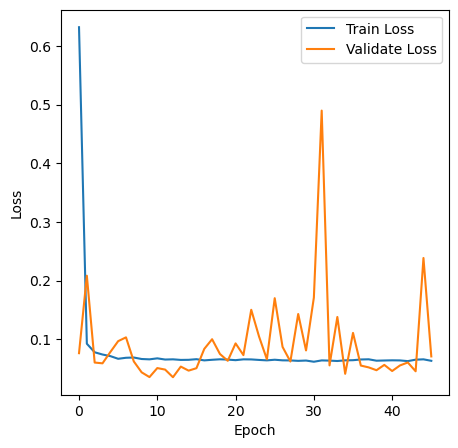

 23%|█████████████████▎                                                         | 46/200 [3:52:44<12:56:24, 302.50s/it]

Epoch:46
Time:3:57:23.713794
Loss:0.07708283405384263
Total:10000  Correct:9778  CleanAccuracy:0.9778


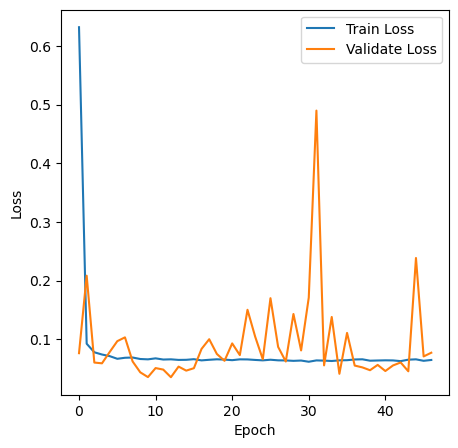

 24%|█████████████████▋                                                         | 47/200 [3:57:37<12:44:03, 299.63s/it]

Epoch:47
Time:4:02:06.082243
Loss:0.09188344265650823
Total:10000  Correct:9692  CleanAccuracy:0.9692


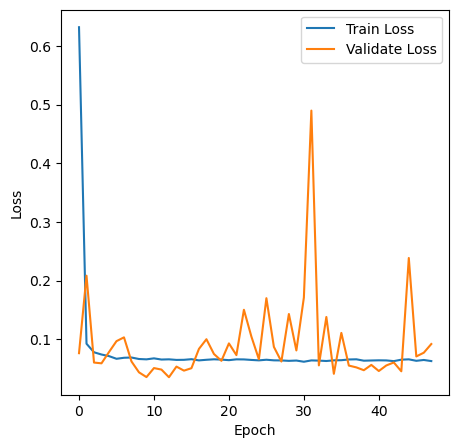

 24%|██████████████████                                                         | 48/200 [4:02:19<12:26:01, 294.48s/it]

Epoch:48
Time:4:07:15.018720
Loss:0.0525142579196622
Total:10000  Correct:9850  CleanAccuracy:0.9850


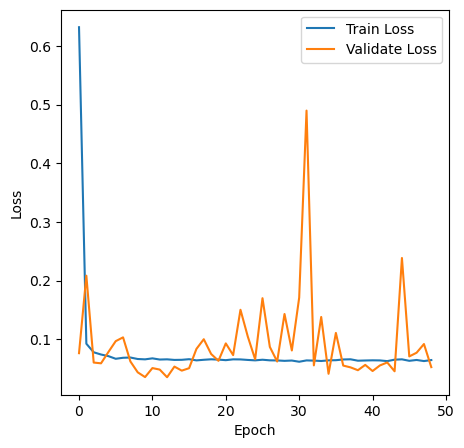

 24%|██████████████████▍                                                        | 49/200 [4:07:30<12:33:26, 299.38s/it]

Epoch:49
Time:4:12:49.544440
Loss:0.07790782194552621
Total:10000  Correct:9750  CleanAccuracy:0.9750


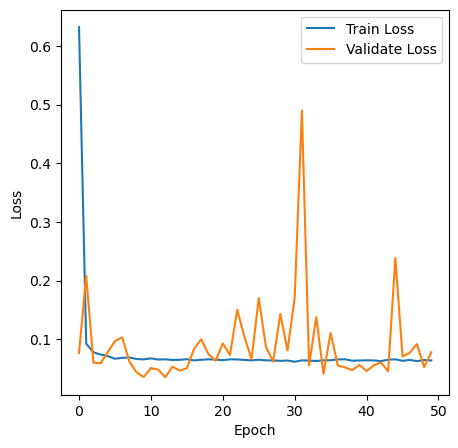

 25%|██████████████████▊                                                        | 50/200 [4:13:02<12:53:23, 309.36s/it]

Epoch:50
Time:4:17:31.412942
Loss:0.05737635857699373
Total:10000  Correct:9820  CleanAccuracy:0.9820


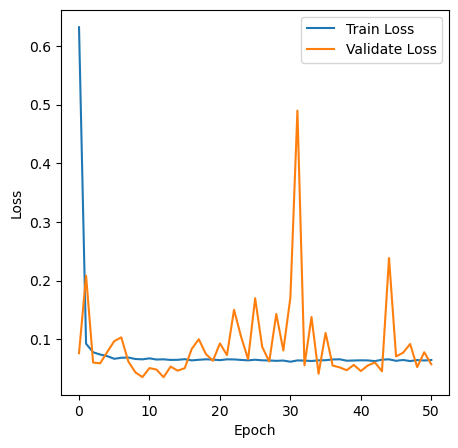

 26%|███████████████████▏                                                       | 51/200 [4:17:44<12:27:52, 301.16s/it]

Epoch:51
Time:4:22:12.087856
Loss:0.08705309883709224
Total:10000  Correct:9744  CleanAccuracy:0.9744


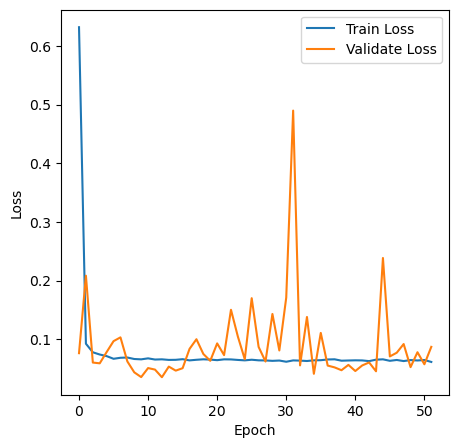

 26%|███████████████████▌                                                       | 52/200 [4:22:25<12:07:39, 295.00s/it]

Epoch:52
Time:4:26:59.697556
Loss:0.09726247602155783
Total:10000  Correct:9688  CleanAccuracy:0.9688


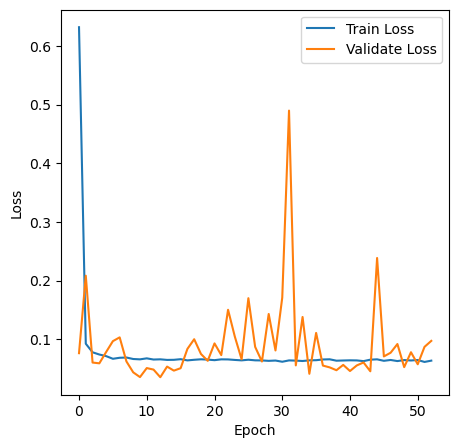

 26%|███████████████████▉                                                       | 53/200 [4:27:14<11:58:09, 293.12s/it]

Epoch:53
Time:4:31:52.906975
Loss:0.05044749187077388
Total:10000  Correct:9841  CleanAccuracy:0.9841


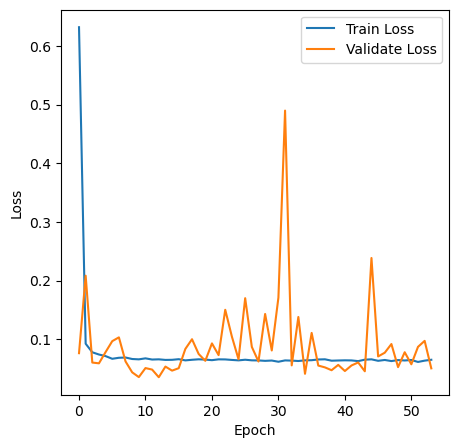

 27%|████████████████████▎                                                      | 54/200 [4:32:05<11:52:07, 292.65s/it]

Epoch:54
Time:4:36:47.948313
Loss:0.05062673651329137
Total:10000  Correct:9840  CleanAccuracy:0.9840


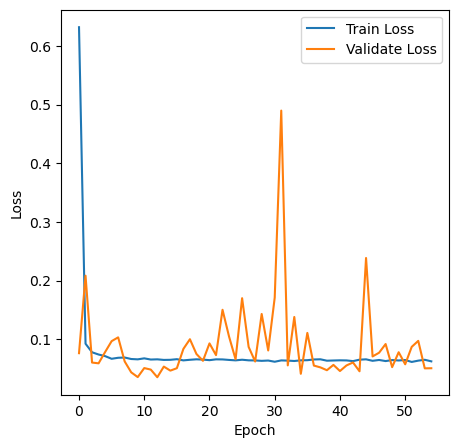

 28%|████████████████████▋                                                      | 55/200 [4:37:02<11:50:00, 293.80s/it]

Epoch:55
Time:4:41:49.311455
Loss:0.062252414936107545
Total:10000  Correct:9830  CleanAccuracy:0.9830


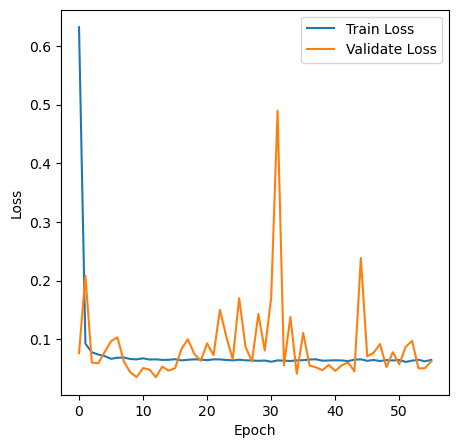

 28%|█████████████████████                                                      | 56/200 [4:42:02<11:49:56, 295.81s/it]

Epoch:56
Time:4:47:01.192195
Loss:0.07820177540263405
Total:10000  Correct:9770  CleanAccuracy:0.9770


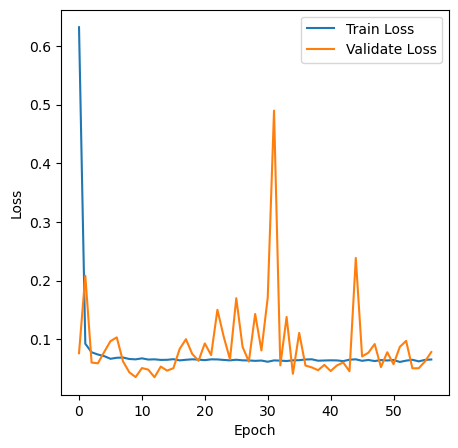

 28%|█████████████████████▎                                                     | 57/200 [4:47:15<11:57:02, 300.86s/it]

Epoch:57
Time:4:51:48.510280
Loss:0.06174820806822195
Total:10000  Correct:9843  CleanAccuracy:0.9843


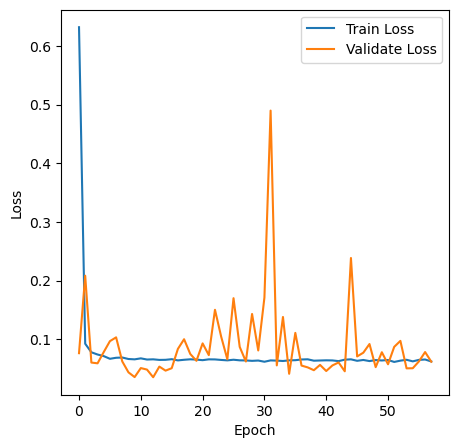

 29%|█████████████████████▊                                                     | 58/200 [4:52:00<11:41:06, 296.24s/it]

Epoch:58
Time:4:56:31.866078
Loss:0.051203391603052845
Total:10000  Correct:9842  CleanAccuracy:0.9842


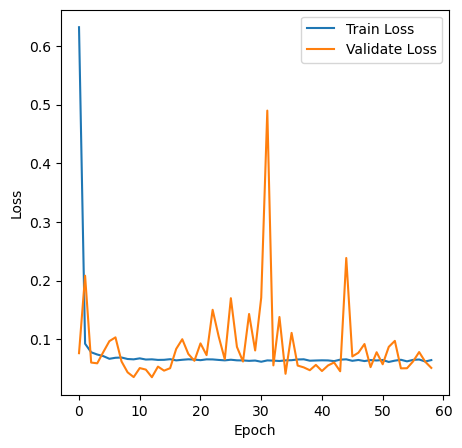

 30%|██████████████████████▏                                                    | 59/200 [4:56:46<11:28:55, 293.16s/it]

Epoch:59
Time:5:01:36.709674
Loss:0.04561462527875173
Total:10000  Correct:9872  CleanAccuracy:0.9872


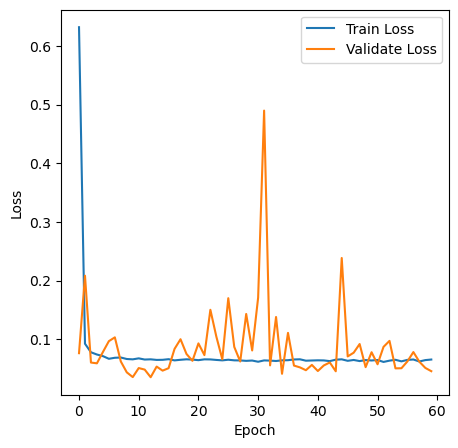

 30%|██████████████████████▌                                                    | 60/200 [5:01:50<11:31:03, 296.17s/it]

Epoch:60
Time:5:06:40.335741
Loss:0.012654174966569329
Total:10000  Correct:9961  CleanAccuracy:0.9961


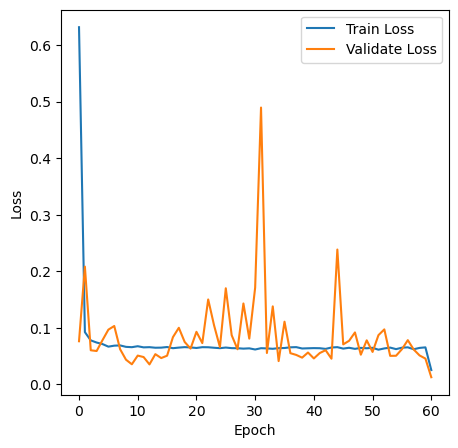

 30%|██████████████████████▉                                                    | 61/200 [5:06:53<11:31:13, 298.37s/it]

Epoch:61
Time:5:11:06.728706
Loss:0.011358616209789603
Total:10000  Correct:9960  CleanAccuracy:0.9960


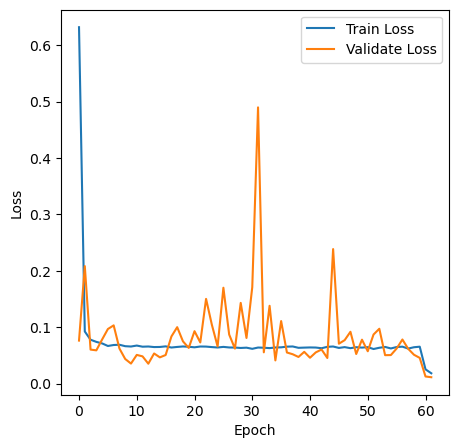

 31%|███████████████████████▎                                                   | 62/200 [5:11:18<11:03:17, 288.39s/it]

Epoch:62
Time:5:15:30.060445
Loss:0.01119637457204677
Total:10000  Correct:9965  CleanAccuracy:0.9965


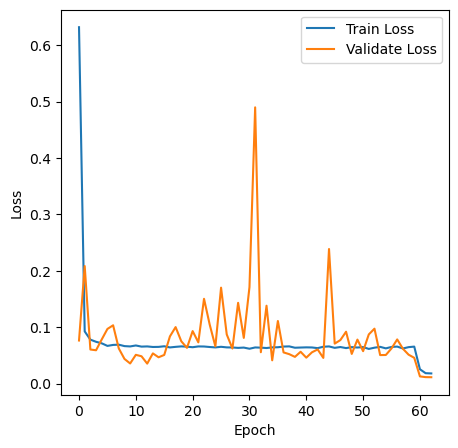

 32%|███████████████████████▋                                                   | 63/200 [5:15:43<10:42:17, 281.30s/it]

Epoch:63
Time:5:19:56.037439
Loss:0.013823426950984402
Total:10000  Correct:9953  CleanAccuracy:0.9953


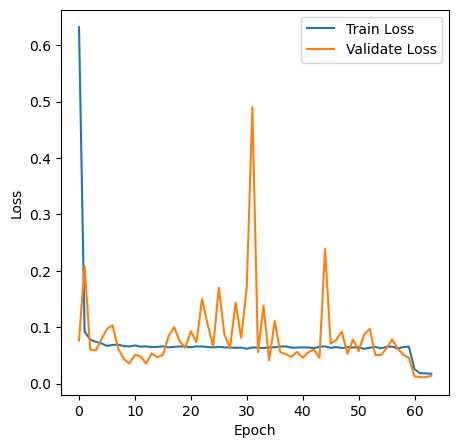

 32%|████████████████████████                                                   | 64/200 [5:20:09<10:27:06, 276.66s/it]

Epoch:64
Time:5:24:21.844775
Loss:0.013500868304089208
Total:10000  Correct:9957  CleanAccuracy:0.9957


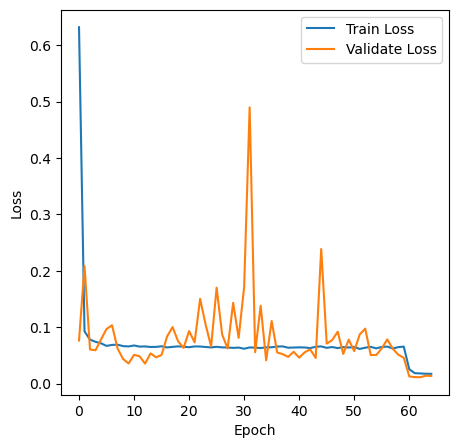

 32%|████████████████████████▍                                                  | 65/200 [5:24:35<10:15:05, 273.37s/it]

Epoch:65
Time:5:28:46.917359
Loss:0.015107910340694084
Total:10000  Correct:9953  CleanAccuracy:0.9953


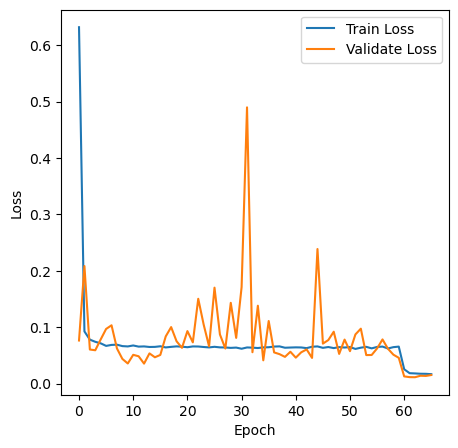

 33%|████████████████████████▊                                                  | 66/200 [5:29:00<10:04:54, 270.86s/it]

Epoch:66
Time:5:33:12.568635
Loss:0.012099788304165039
Total:10000  Correct:9966  CleanAccuracy:0.9966


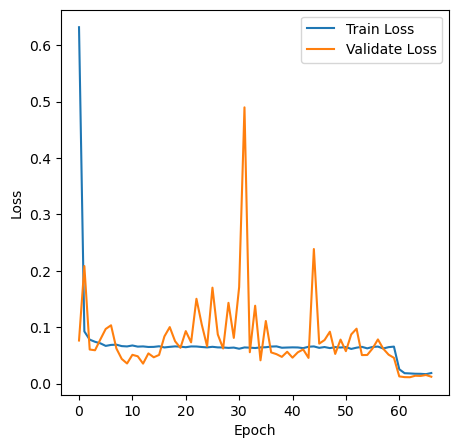

 34%|█████████████████████████▍                                                  | 67/200 [5:33:26<9:57:14, 269.43s/it]

Epoch:67
Time:5:37:38.977994
Loss:0.02266042521471692
Total:10000  Correct:9934  CleanAccuracy:0.9934


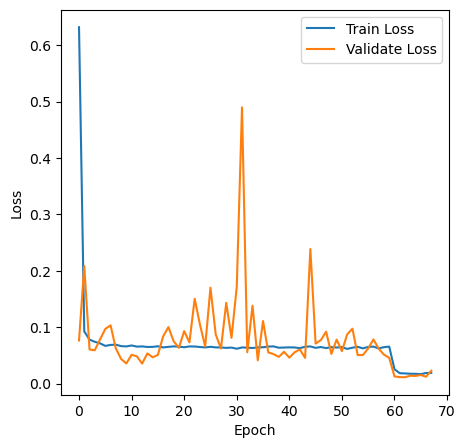

 34%|█████████████████████████▊                                                  | 68/200 [5:37:50<9:49:43, 268.06s/it]

Epoch:68
Time:5:42:03.519457
Loss:0.016768519919865523
Total:10000  Correct:9942  CleanAccuracy:0.9942


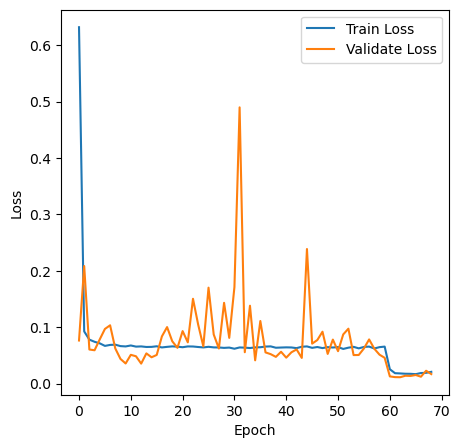

 34%|██████████████████████████▏                                                 | 69/200 [5:42:16<9:43:47, 267.38s/it]

Epoch:69
Time:5:46:28.607009
Loss:0.016612991647537836
Total:10000  Correct:9955  CleanAccuracy:0.9955


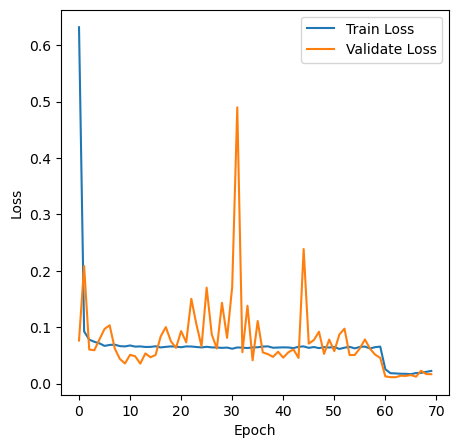

 35%|██████████████████████████▌                                                 | 70/200 [5:46:41<9:37:26, 266.51s/it]

Epoch:70
Time:5:50:53.608421
Loss:0.02327901385991407
Total:10000  Correct:9931  CleanAccuracy:0.9931


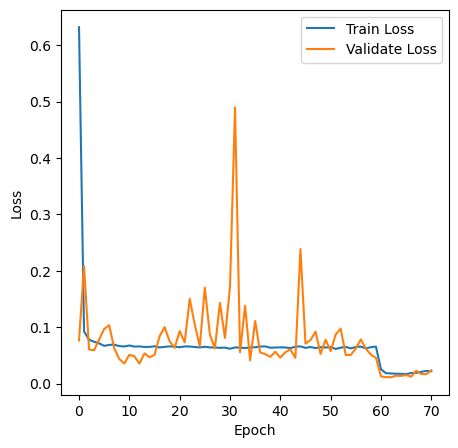

 36%|██████████████████████████▉                                                 | 71/200 [5:51:06<9:32:28, 266.26s/it]

Epoch:71
Time:5:55:20.190774
Loss:0.017389489309488464
Total:10000  Correct:9938  CleanAccuracy:0.9938


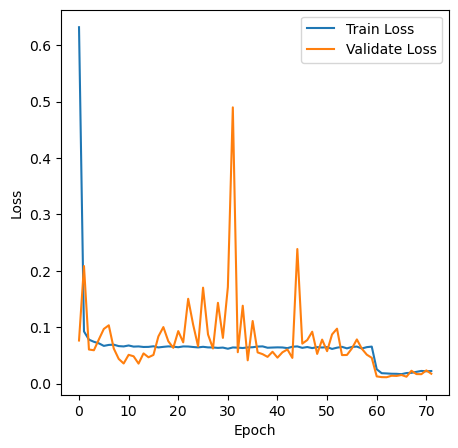

 36%|███████████████████████████▎                                                | 72/200 [5:55:33<9:28:08, 266.31s/it]

Epoch:72
Time:5:59:45.954965
Loss:0.016576000146417934
Total:10000  Correct:9945  CleanAccuracy:0.9945


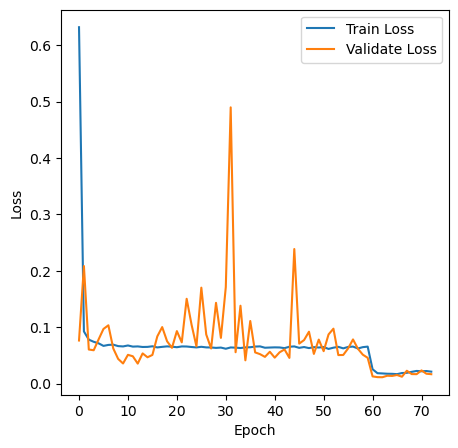

 36%|███████████████████████████▋                                                | 73/200 [5:59:59<9:23:30, 266.23s/it]

Epoch:73
Time:6:04:11.902273
Loss:0.029605627431684493
Total:10000  Correct:9905  CleanAccuracy:0.9905


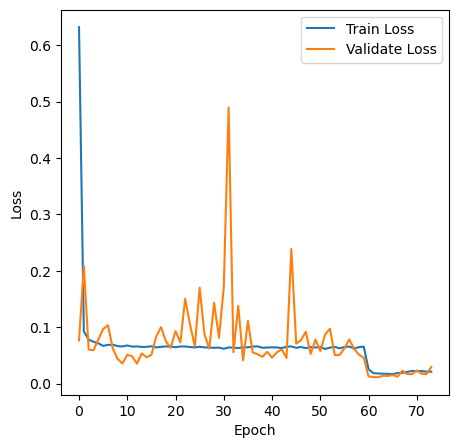

 37%|████████████████████████████                                                | 74/200 [6:04:25<9:18:42, 266.06s/it]

Epoch:74
Time:6:08:40.496177
Loss:0.02019372698111711
Total:10000  Correct:9936  CleanAccuracy:0.9936


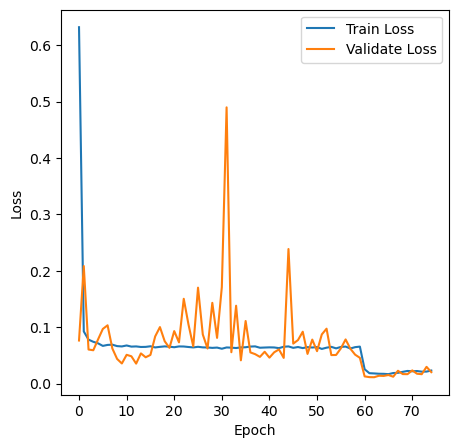

 38%|████████████████████████████▌                                               | 75/200 [6:08:53<9:15:48, 266.79s/it]

Epoch:75
Time:6:13:06.277186
Loss:0.019098118185244217
Total:10000  Correct:9940  CleanAccuracy:0.9940


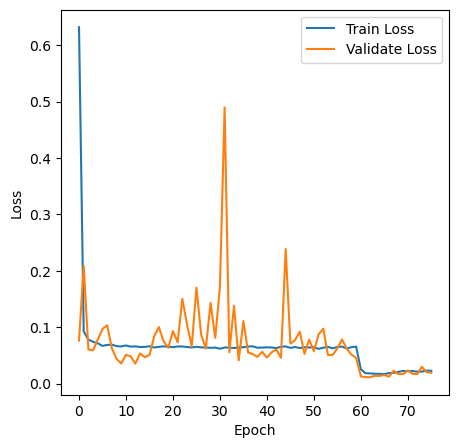

 38%|████████████████████████████▉                                               | 76/200 [6:13:18<9:10:28, 266.36s/it]

Epoch:76
Time:6:17:31.626777
Loss:0.03365124343455912
Total:10000  Correct:9896  CleanAccuracy:0.9896


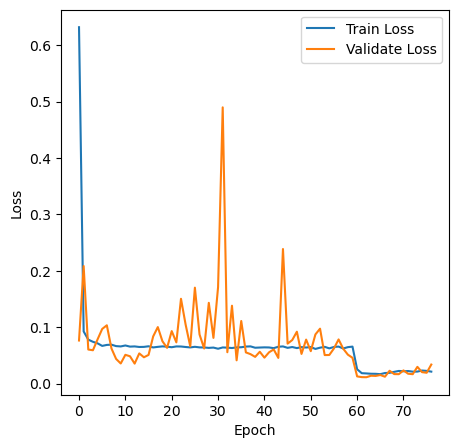

 38%|█████████████████████████████▎                                              | 77/200 [6:17:44<9:05:45, 266.22s/it]

Epoch:77
Time:6:21:57.184176
Loss:0.024285018941522917
Total:10000  Correct:9932  CleanAccuracy:0.9932


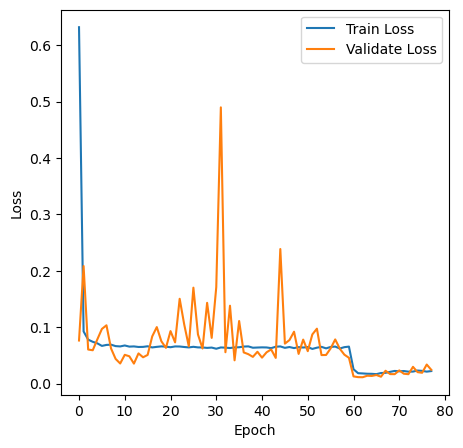

 39%|█████████████████████████████▋                                              | 78/200 [6:22:10<9:01:06, 266.12s/it]

Epoch:78
Time:6:26:22.810513
Loss:0.017761326087990213
Total:10000  Correct:9942  CleanAccuracy:0.9942


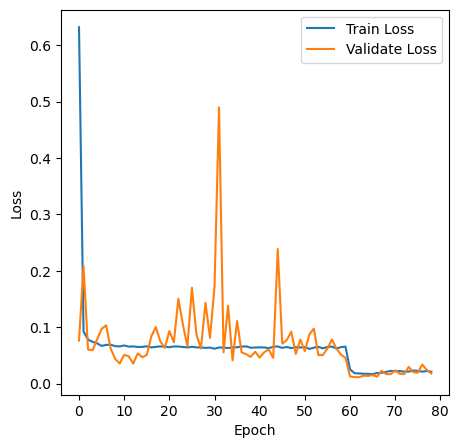

 40%|██████████████████████████████                                              | 79/200 [6:26:36<8:56:18, 265.94s/it]

Epoch:79
Time:6:30:49.540032
Loss:0.026081595028080745
Total:10000  Correct:9916  CleanAccuracy:0.9916


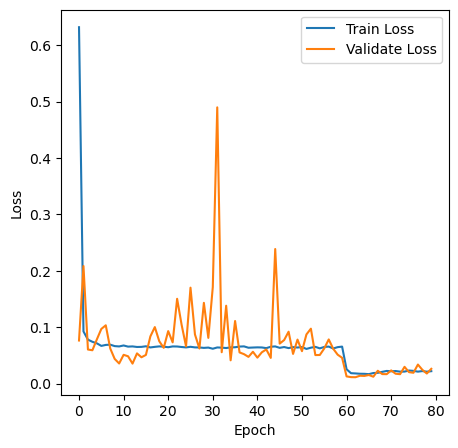

 40%|██████████████████████████████▍                                             | 80/200 [6:31:02<8:52:14, 266.12s/it]

Epoch:80
Time:6:35:15.394258
Loss:0.01522900409380587
Total:10000  Correct:9950  CleanAccuracy:0.9950


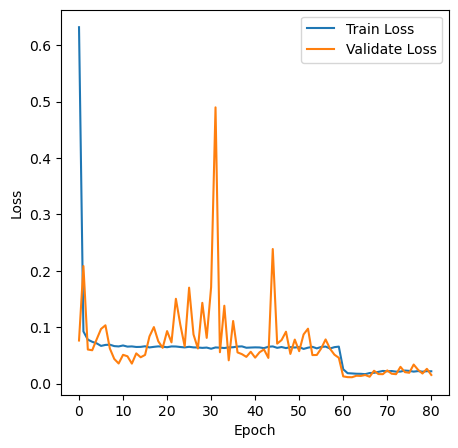

 40%|██████████████████████████████▊                                             | 81/200 [6:35:28<8:47:39, 266.05s/it]

Epoch:81
Time:6:39:40.763174
Loss:0.019592145889353665
Total:10000  Correct:9934  CleanAccuracy:0.9934


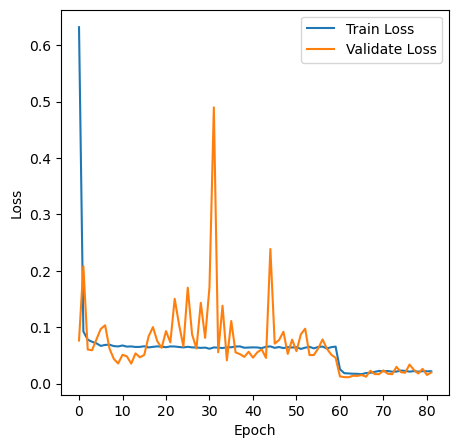

 41%|███████████████████████████████▏                                            | 82/200 [6:39:54<8:42:55, 265.90s/it]

Epoch:82
Time:6:44:06.331693
Loss:0.024215983208019685
Total:10000  Correct:9926  CleanAccuracy:0.9926


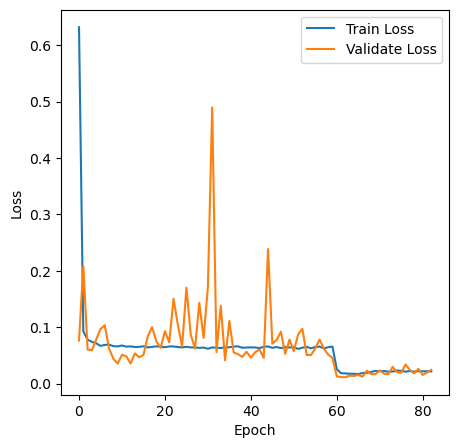

 42%|███████████████████████████████▌                                            | 83/200 [6:44:19<8:38:07, 265.70s/it]

Epoch:83
Time:6:48:32.451330
Loss:0.018379571739059408
Total:10000  Correct:9946  CleanAccuracy:0.9946


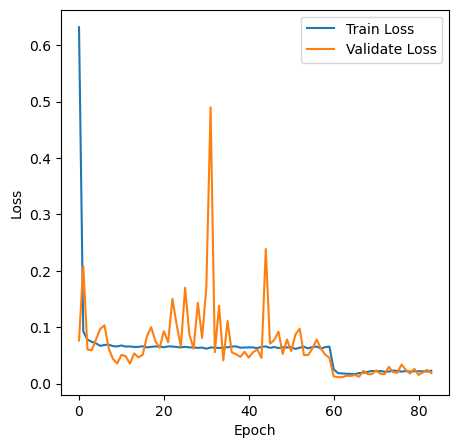

 42%|███████████████████████████████▉                                            | 84/200 [6:48:45<8:33:47, 265.75s/it]

Epoch:84
Time:6:52:57.618443
Loss:0.022226426565291408
Total:10000  Correct:9932  CleanAccuracy:0.9932


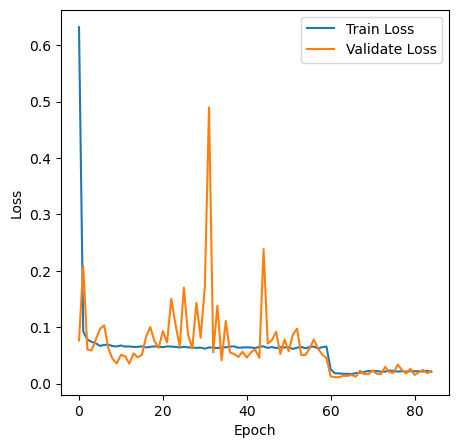

 42%|████████████████████████████████▎                                           | 85/200 [6:53:10<8:29:11, 265.67s/it]

Epoch:85
Time:6:57:23.175443
Loss:0.03362449295536136
Total:10000  Correct:9909  CleanAccuracy:0.9909


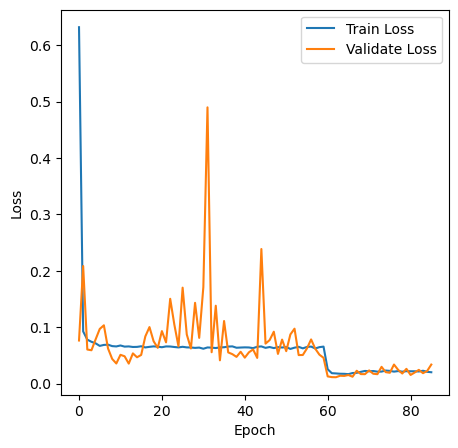

 43%|████████████████████████████████▋                                           | 86/200 [6:57:35<8:24:17, 265.42s/it]

Epoch:86
Time:7:01:59.335764
Loss:0.01931131603361774
Total:10000  Correct:9943  CleanAccuracy:0.9943


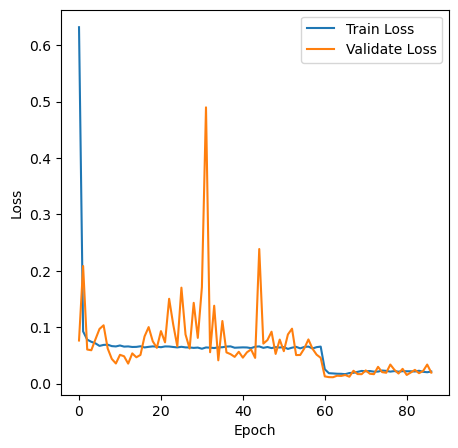

 44%|█████████████████████████████████                                           | 87/200 [7:02:12<8:26:20, 268.86s/it]

Epoch:87
Time:7:06:35.689615
Loss:0.02083281055315972
Total:10000  Correct:9942  CleanAccuracy:0.9942


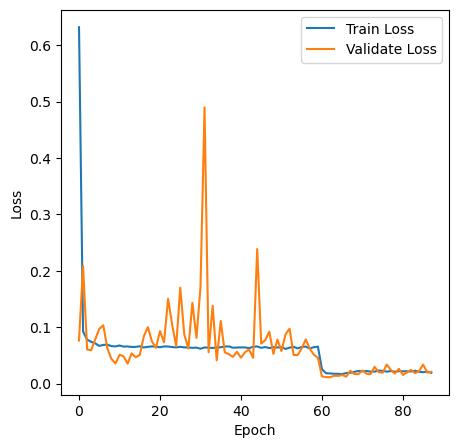

 44%|█████████████████████████████████▍                                          | 88/200 [7:06:48<8:26:08, 271.15s/it]

Epoch:88
Time:7:11:17.812359
Loss:0.01720077261092891
Total:10000  Correct:9951  CleanAccuracy:0.9951


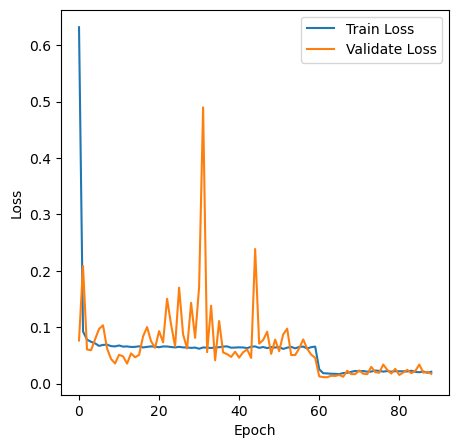

 44%|█████████████████████████████████▊                                          | 89/200 [7:11:31<8:27:54, 274.55s/it]

Epoch:89
Time:7:15:57.658861
Loss:0.026322465145792336
Total:10000  Correct:9918  CleanAccuracy:0.9918


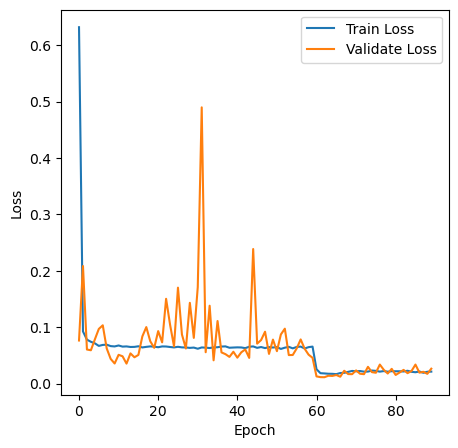

 45%|██████████████████████████████████▏                                         | 90/200 [7:16:09<8:25:21, 275.65s/it]

Epoch:90
Time:7:20:22.138133
Loss:0.021625180877879048
Total:10000  Correct:9934  CleanAccuracy:0.9934


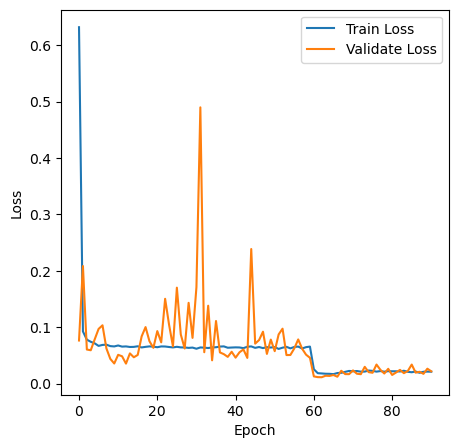

 46%|██████████████████████████████████▌                                         | 91/200 [7:20:35<8:15:14, 272.61s/it]

Epoch:91
Time:7:24:48.786474
Loss:0.023182438078889485
Total:10000  Correct:9932  CleanAccuracy:0.9932


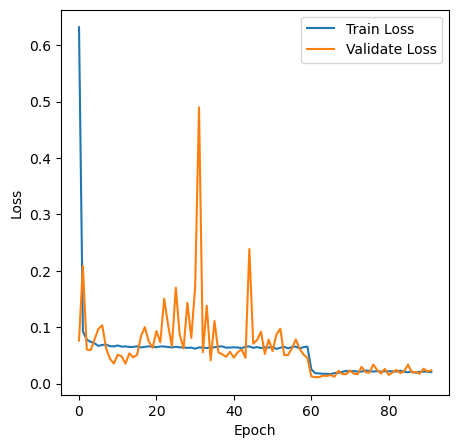

 46%|██████████████████████████████████▉                                         | 92/200 [7:25:03<8:08:18, 271.28s/it]

Epoch:92
Time:7:29:24.075625
Loss:0.020793371260617696
Total:10000  Correct:9937  CleanAccuracy:0.9937


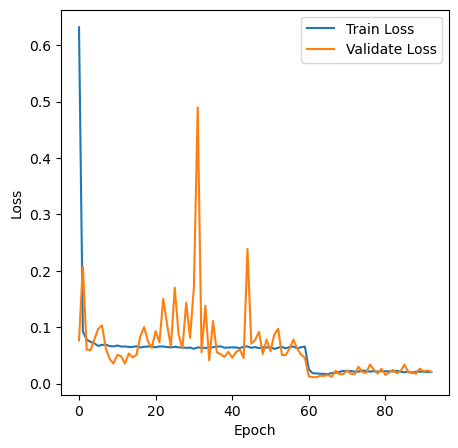

 46%|███████████████████████████████████▎                                        | 93/200 [7:29:37<8:05:07, 272.03s/it]

Epoch:93
Time:7:33:55.221637
Loss:0.018283042457726852
Total:10000  Correct:9944  CleanAccuracy:0.9944


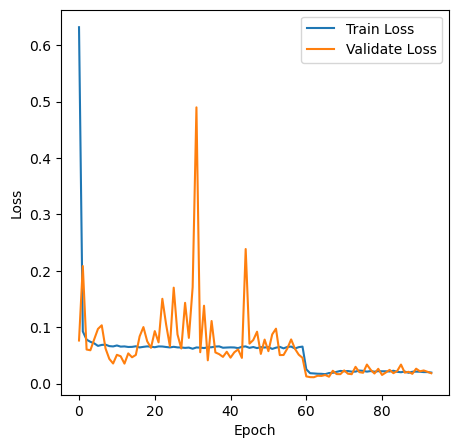

 47%|███████████████████████████████████▋                                        | 94/200 [7:34:08<8:00:11, 271.81s/it]

Epoch:94
Time:7:38:37.615350
Loss:0.018318075154874155
Total:10000  Correct:9944  CleanAccuracy:0.9944


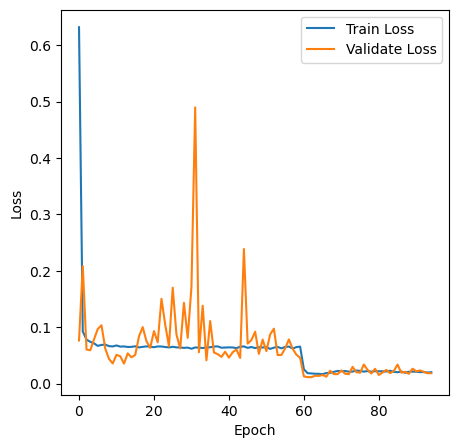

 48%|████████████████████████████████████                                        | 95/200 [7:38:53<8:02:32, 275.74s/it]

Epoch:95
Time:7:43:11.711426
Loss:0.026762563622271727
Total:10000  Correct:9914  CleanAccuracy:0.9914


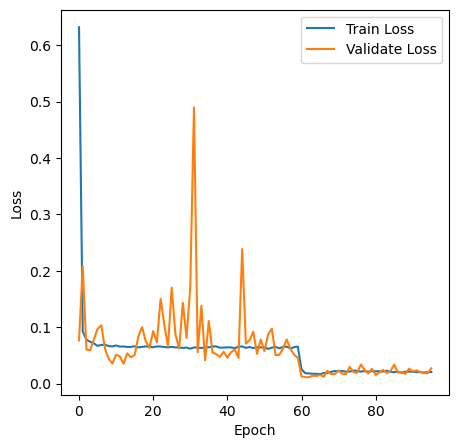

 48%|████████████████████████████████████▍                                       | 96/200 [7:43:24<7:55:40, 274.43s/it]

Epoch:96
Time:7:48:04.277125
Loss:0.019339096817749958
Total:10000  Correct:9939  CleanAccuracy:0.9939


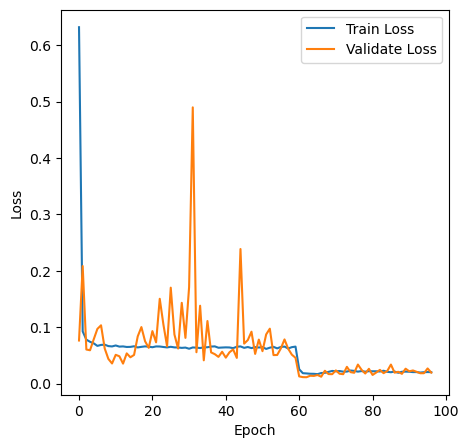

 48%|████████████████████████████████████▊                                       | 97/200 [7:48:19<8:01:31, 280.50s/it]

Epoch:97
Time:7:53:25.065668
Loss:0.026303437713718864
Total:10000  Correct:9927  CleanAccuracy:0.9927


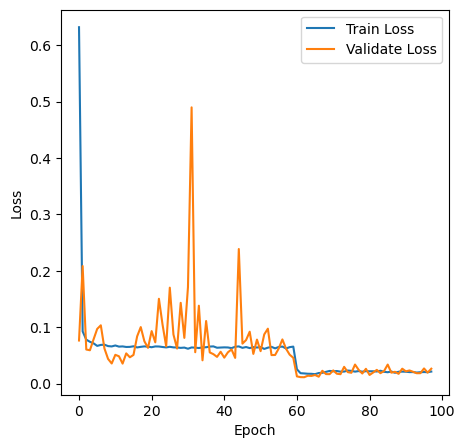

 49%|█████████████████████████████████████▏                                      | 98/200 [7:53:39<8:17:16, 292.52s/it]

Epoch:98
Time:7:58:27.613840
Loss:0.020244970186433113
Total:10000  Correct:9938  CleanAccuracy:0.9938


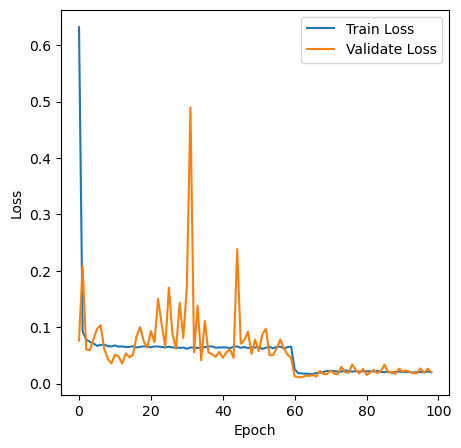

 50%|█████████████████████████████████████▌                                      | 99/200 [7:58:40<8:16:28, 294.94s/it]

Epoch:99
Time:8:03:00.747485
Loss:0.01743059239223616
Total:10000  Correct:9947  CleanAccuracy:0.9947


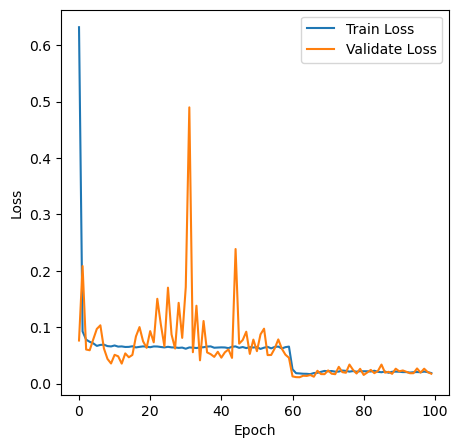

 50%|█████████████████████████████████████▌                                     | 100/200 [8:03:15<8:01:37, 288.97s/it]

Epoch:100
Time:8:08:02.695246
Loss:0.016255134319869455
Total:10000  Correct:9951  CleanAccuracy:0.9951


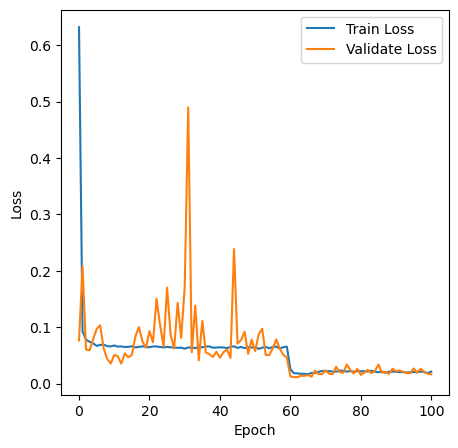

 50%|█████████████████████████████████████▉                                     | 101/200 [8:08:17<8:03:23, 292.96s/it]

Epoch:101
Time:8:12:51.255211
Loss:0.022754122387802306
Total:10000  Correct:9939  CleanAccuracy:0.9939


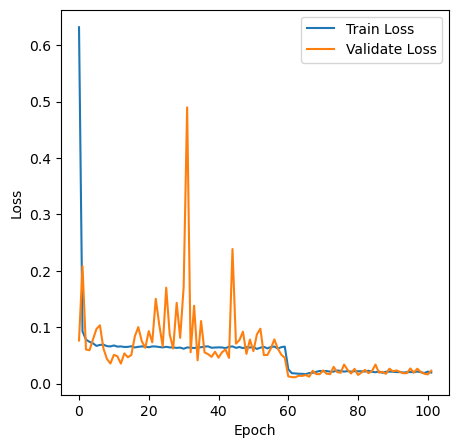

 51%|██████████████████████████████████████▎                                    | 102/200 [8:13:05<7:55:49, 291.32s/it]

Epoch:102
Time:8:17:39.202916
Loss:0.029189949390012026
Total:10000  Correct:9919  CleanAccuracy:0.9919


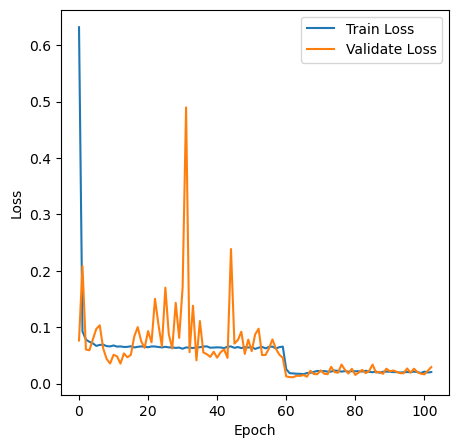

 52%|██████████████████████████████████████▋                                    | 103/200 [8:17:52<7:49:10, 290.21s/it]

Epoch:103
Time:8:22:04.603128
Loss:0.02540321720555014
Total:10000  Correct:9927  CleanAccuracy:0.9927


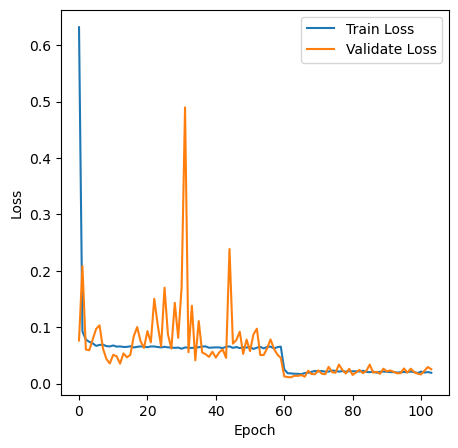

 52%|███████████████████████████████████████                                    | 104/200 [8:22:16<7:31:41, 282.31s/it]

Epoch:104
Time:8:26:29.006826
Loss:0.02092354897649203
Total:10000  Correct:9930  CleanAccuracy:0.9930


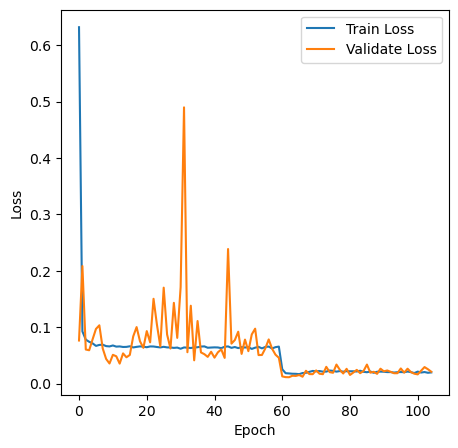

 52%|███████████████████████████████████████▍                                   | 105/200 [8:26:42<7:19:01, 277.28s/it]

Epoch:105
Time:8:31:04.903913
Loss:0.019881087781273024
Total:10000  Correct:9942  CleanAccuracy:0.9942


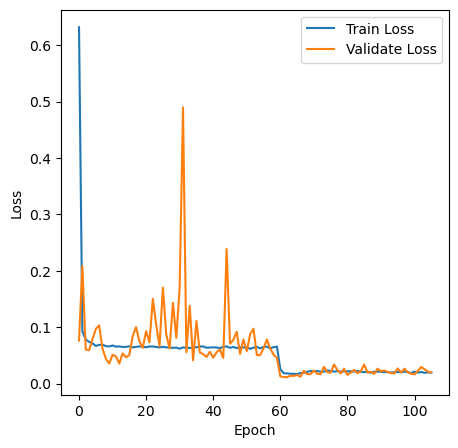

 53%|███████████████████████████████████████▊                                   | 106/200 [8:31:17<7:13:35, 276.76s/it]

Epoch:106
Time:8:35:33.022116
Loss:0.02114223517844239
Total:10000  Correct:9944  CleanAccuracy:0.9944


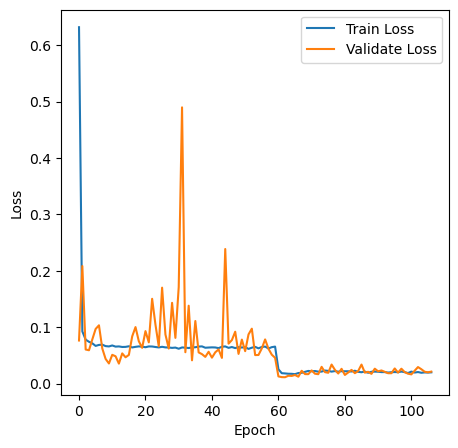

 54%|████████████████████████████████████████▏                                  | 107/200 [8:35:46<7:05:16, 274.37s/it]

Epoch:107
Time:8:39:54.239046
Loss:0.021351380208099912
Total:10000  Correct:9937  CleanAccuracy:0.9937


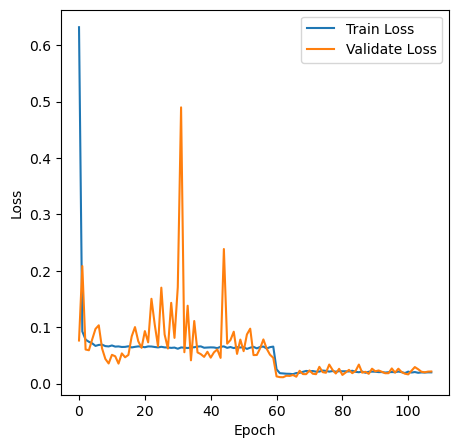

 54%|████████████████████████████████████████▌                                  | 108/200 [8:40:07<6:54:37, 270.41s/it]

Epoch:108
Time:8:44:26.387041
Loss:0.026666142223585106
Total:10000  Correct:9920  CleanAccuracy:0.9920


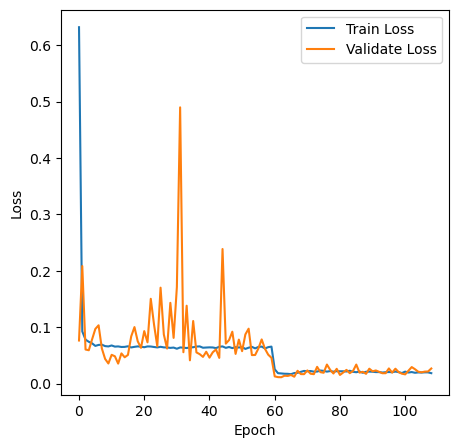

 55%|████████████████████████████████████████▉                                  | 109/200 [8:44:40<6:51:03, 271.03s/it]

Epoch:109
Time:8:49:02.024592
Loss:0.020271031094023947
Total:10000  Correct:9931  CleanAccuracy:0.9931


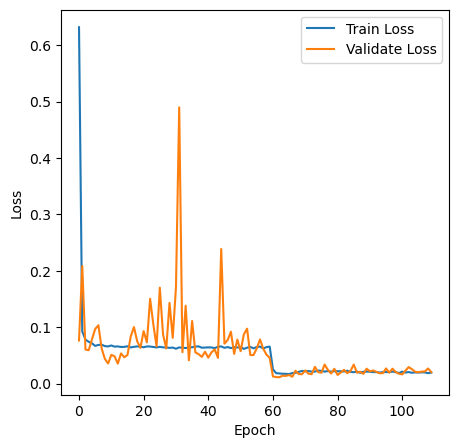

 55%|█████████████████████████████████████████▎                                 | 110/200 [8:49:15<6:48:25, 272.28s/it]

Epoch:110
Time:8:53:32.011807
Loss:0.02201812055485231
Total:10000  Correct:9929  CleanAccuracy:0.9929


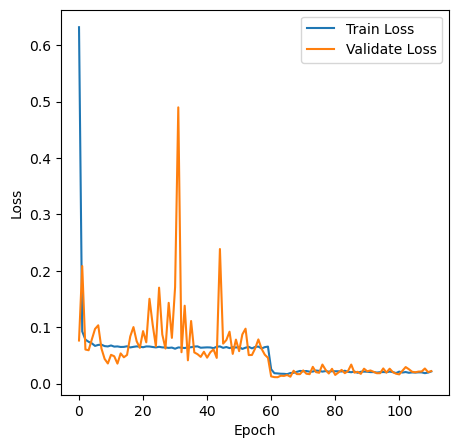

 56%|█████████████████████████████████████████▋                                 | 111/200 [8:53:45<6:42:48, 271.55s/it]

Epoch:111
Time:8:57:59.859562
Loss:0.019028575407270827
Total:10000  Correct:9942  CleanAccuracy:0.9942


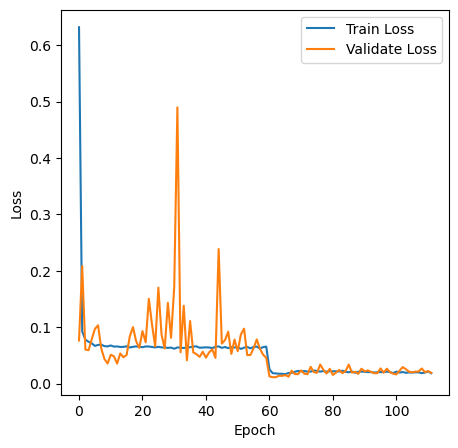

 56%|██████████████████████████████████████████                                 | 112/200 [8:58:13<6:36:34, 270.39s/it]

Epoch:112
Time:9:02:27.389984
Loss:0.019176848554097046
Total:10000  Correct:9943  CleanAccuracy:0.9943


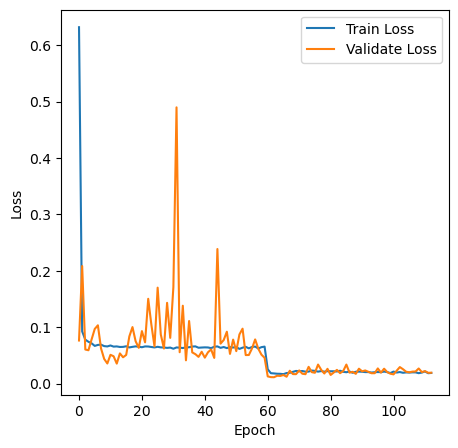

 56%|██████████████████████████████████████████▎                                | 113/200 [9:02:41<6:31:00, 269.66s/it]

Epoch:113
Time:9:06:56.218247
Loss:0.02259847873408264
Total:10000  Correct:9937  CleanAccuracy:0.9937


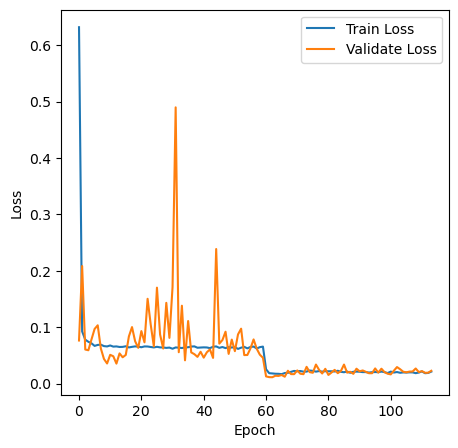

 57%|██████████████████████████████████████████▋                                | 114/200 [9:07:09<6:25:54, 269.24s/it]

Epoch:114
Time:9:11:23.175683
Loss:0.021193581327958518
Total:10000  Correct:9940  CleanAccuracy:0.9940


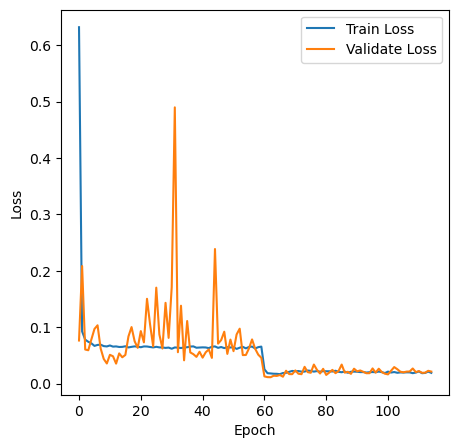

 57%|███████████████████████████████████████████▏                               | 115/200 [9:11:36<6:20:36, 268.67s/it]

Epoch:115
Time:9:15:50.436987
Loss:0.018251905418611086
Total:10000  Correct:9948  CleanAccuracy:0.9948


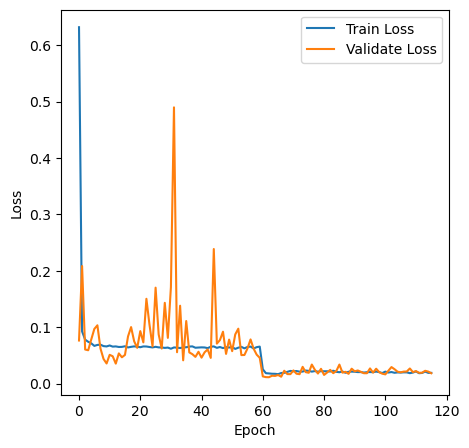

 58%|███████████████████████████████████████████▌                               | 116/200 [9:16:03<6:15:31, 268.23s/it]

Epoch:116
Time:9:20:17.749167
Loss:0.01783290766195369
Total:10000  Correct:9941  CleanAccuracy:0.9941


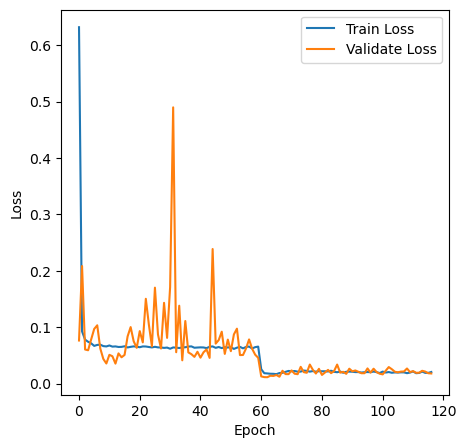

 58%|███████████████████████████████████████████▉                               | 117/200 [9:20:31<6:10:44, 268.00s/it]

Epoch:117
Time:9:24:45.267502
Loss:0.019206914428685502
Total:10000  Correct:9940  CleanAccuracy:0.9940


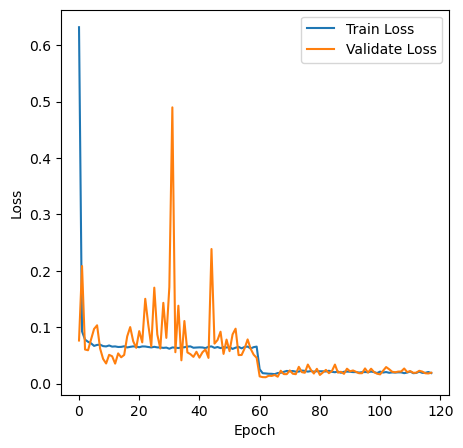

 59%|████████████████████████████████████████████▎                              | 118/200 [9:24:57<6:05:40, 267.57s/it]

Epoch:118
Time:9:29:11.564521
Loss:0.02417420565822763
Total:10000  Correct:9934  CleanAccuracy:0.9934


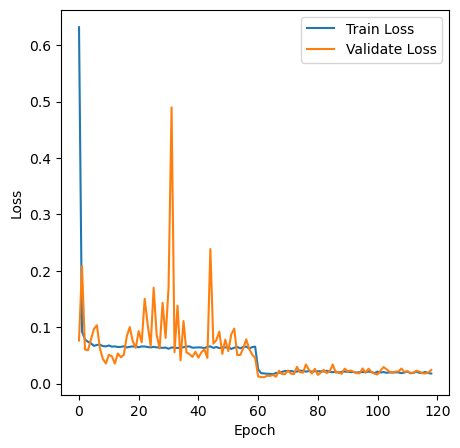

 60%|████████████████████████████████████████████▋                              | 119/200 [9:29:24<6:00:47, 267.26s/it]

Epoch:119
Time:9:33:39.206872
Loss:0.017427084573894924
Total:10000  Correct:9945  CleanAccuracy:0.9945


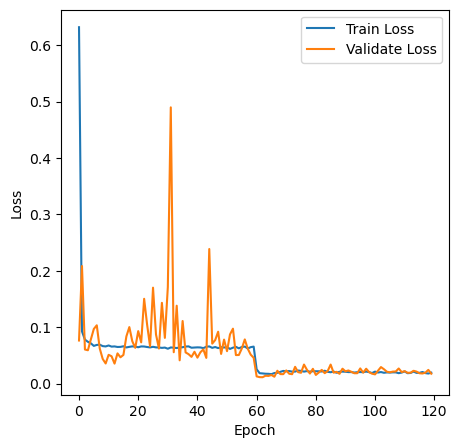

 60%|█████████████████████████████████████████████                              | 120/200 [9:33:52<5:56:39, 267.49s/it]

Epoch:120
Time:9:38:08.242921
Loss:0.010499853980230962
Total:10000  Correct:9974  CleanAccuracy:0.9974


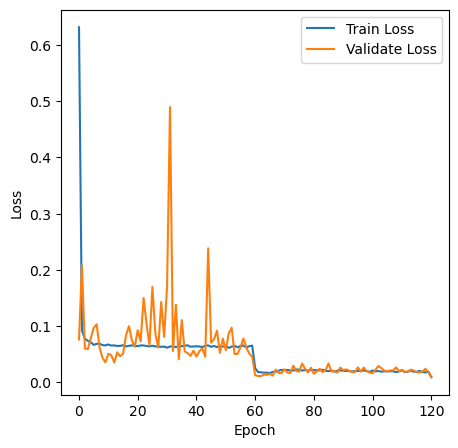

 60%|█████████████████████████████████████████████▍                             | 121/200 [9:38:22<5:53:00, 268.11s/it]

Epoch:121
Time:9:42:35.826607
Loss:0.009662200872598144
Total:10000  Correct:9970  CleanAccuracy:0.9970


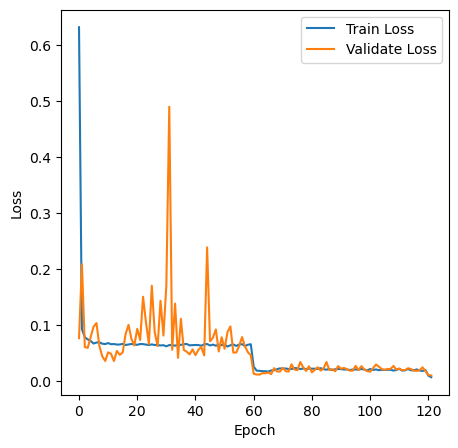

 61%|█████████████████████████████████████████████▊                             | 122/200 [9:42:49<5:48:08, 267.81s/it]

Epoch:122
Time:9:47:03.411210
Loss:0.009789431078795392
Total:10000  Correct:9972  CleanAccuracy:0.9972


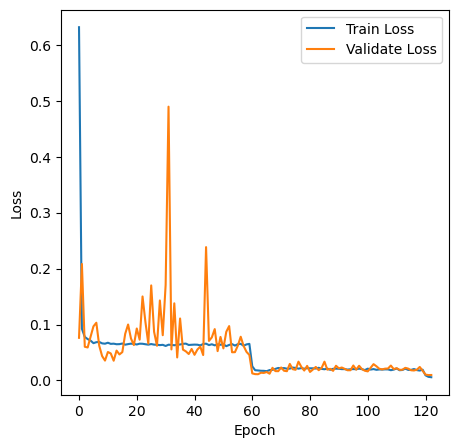

 62%|██████████████████████████████████████████████▏                            | 123/200 [9:47:17<5:43:47, 267.88s/it]

Epoch:123
Time:9:51:32.443098
Loss:0.00980474833294358
Total:10000  Correct:9976  CleanAccuracy:0.9976


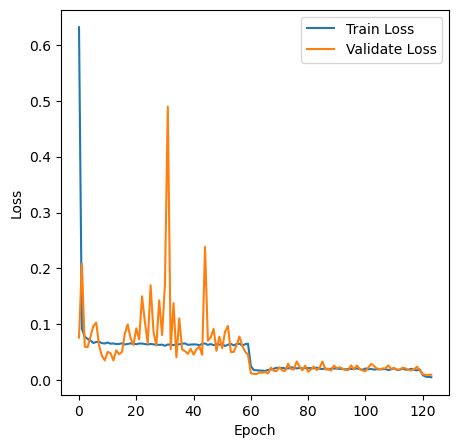

 62%|██████████████████████████████████████████████▌                            | 124/200 [9:51:46<5:39:40, 268.17s/it]

Epoch:124
Time:9:56:02.323462
Loss:0.009571258005968402
Total:10000  Correct:9976  CleanAccuracy:0.9976


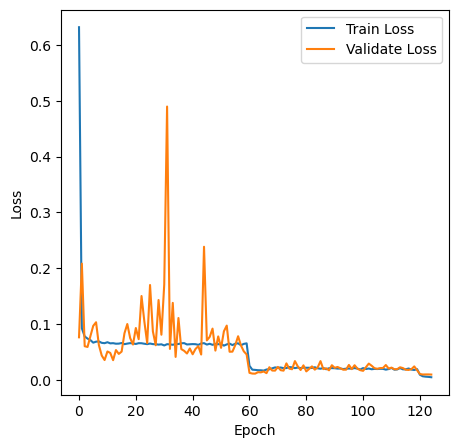

 62%|██████████████████████████████████████████████▉                            | 125/200 [9:56:15<5:35:44, 268.59s/it]

Epoch:125
Time:10:00:30.580267
Loss:0.009178213470730003
Total:10000  Correct:9974  CleanAccuracy:0.9974


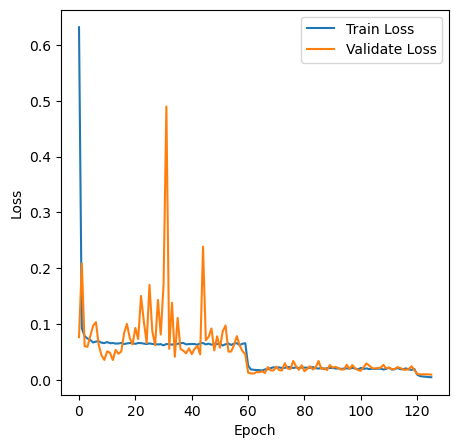

 63%|██████████████████████████████████████████████▌                           | 126/200 [10:00:43<5:31:06, 268.47s/it]

Epoch:126
Time:10:05:01.286949
Loss:0.010065030379848667
Total:10000  Correct:9970  CleanAccuracy:0.9970


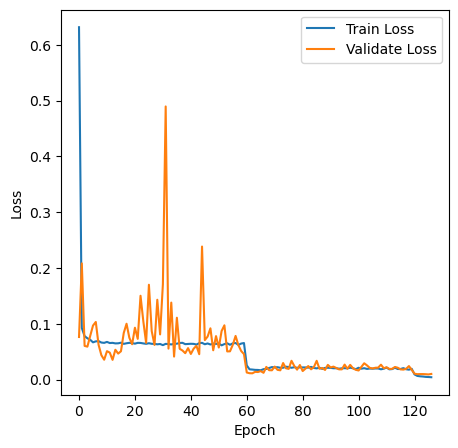

 64%|██████████████████████████████████████████████▉                           | 127/200 [10:05:14<5:27:33, 269.22s/it]

Epoch:127
Time:10:09:33.157171
Loss:0.010384517539956103
Total:10000  Correct:9971  CleanAccuracy:0.9971


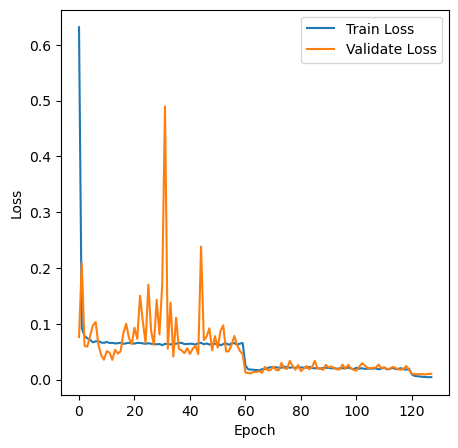

 64%|███████████████████████████████████████████████▎                          | 128/200 [10:09:46<5:23:55, 269.93s/it]

Epoch:128
Time:10:14:02.387781
Loss:0.010595000741282513
Total:10000  Correct:9971  CleanAccuracy:0.9971


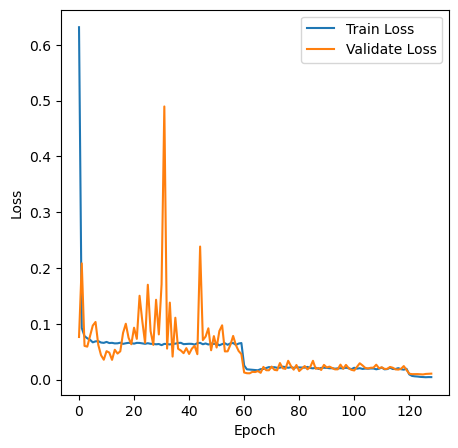

 64%|███████████████████████████████████████████████▋                          | 129/200 [10:14:16<5:19:20, 269.87s/it]

Epoch:129
Time:10:18:30.527746
Loss:0.011432323532388025
Total:10000  Correct:9971  CleanAccuracy:0.9971


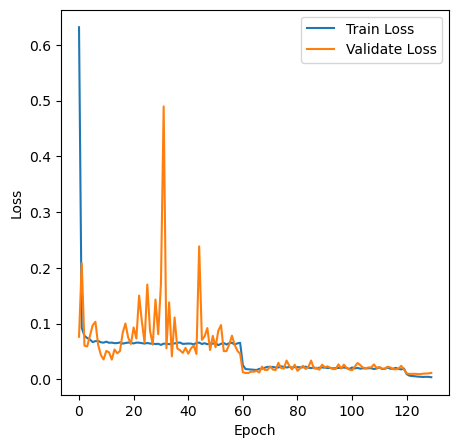

 65%|████████████████████████████████████████████████                          | 130/200 [10:18:43<5:14:04, 269.20s/it]

Epoch:130
Time:10:23:00.416598
Loss:0.010727427663566462
Total:10000  Correct:9968  CleanAccuracy:0.9968


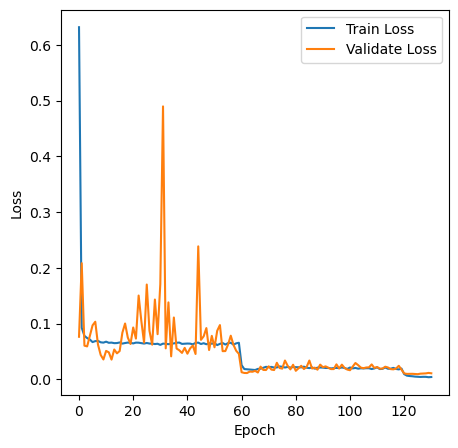

 66%|████████████████████████████████████████████████▍                         | 131/200 [10:23:13<5:09:56, 269.52s/it]

Epoch:131
Time:10:27:31.816464
Loss:0.010348514521240849
Total:10000  Correct:9972  CleanAccuracy:0.9972


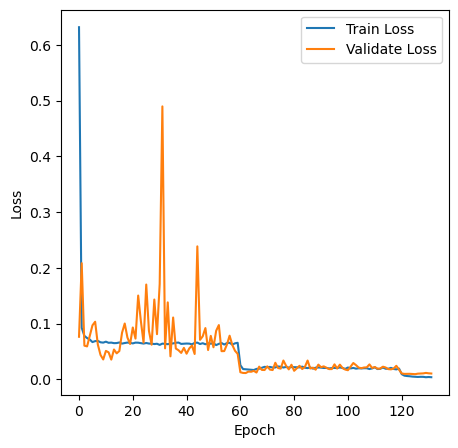

 66%|████████████████████████████████████████████████▊                         | 132/200 [10:27:45<5:06:01, 270.03s/it]

Epoch:132
Time:10:32:02.977665
Loss:0.011174958901566872
Total:10000  Correct:9975  CleanAccuracy:0.9975


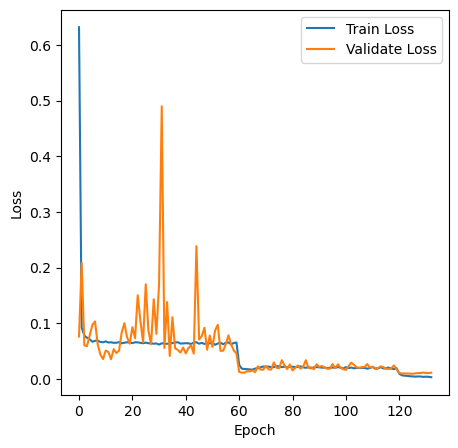

 66%|█████████████████████████████████████████████████▏                        | 133/200 [10:32:16<5:01:59, 270.44s/it]

Epoch:133
Time:10:36:33.551471
Loss:0.011512707830919995
Total:10000  Correct:9972  CleanAccuracy:0.9972


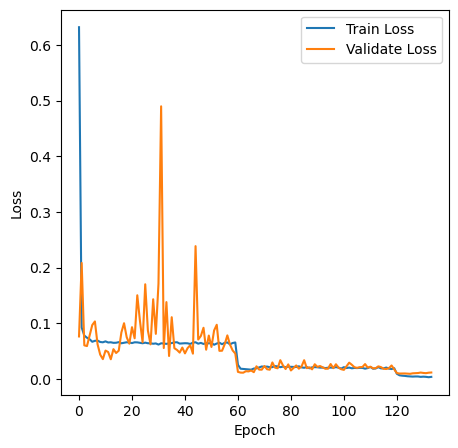

 67%|█████████████████████████████████████████████████▌                        | 134/200 [10:36:47<4:57:28, 270.43s/it]

Epoch:134
Time:10:41:05.048618
Loss:0.010628956611254833
Total:10000  Correct:9970  CleanAccuracy:0.9970


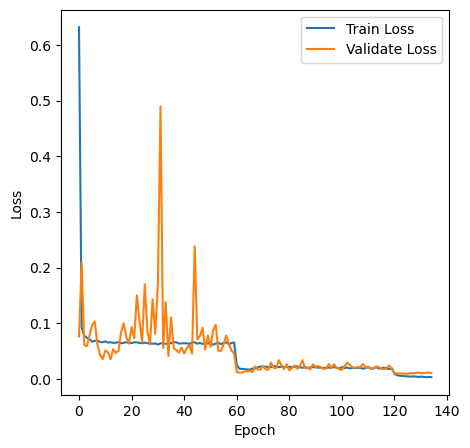

 68%|█████████████████████████████████████████████████▉                        | 135/200 [10:41:18<4:53:20, 270.78s/it]

Epoch:135
Time:10:45:35.499872
Loss:0.009685027308649749
Total:10000  Correct:9970  CleanAccuracy:0.9970


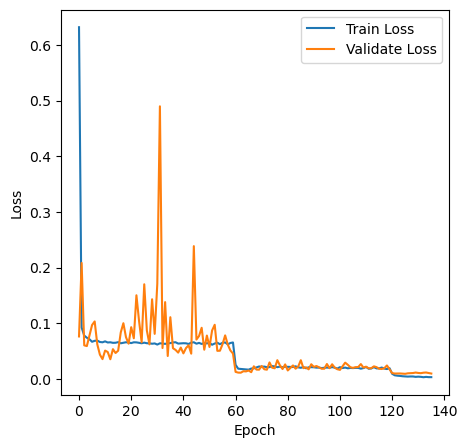

 68%|██████████████████████████████████████████████████▎                       | 136/200 [10:45:48<4:48:38, 270.61s/it]

Epoch:136
Time:10:50:06.531802
Loss:0.011042761715343252
Total:10000  Correct:9969  CleanAccuracy:0.9969


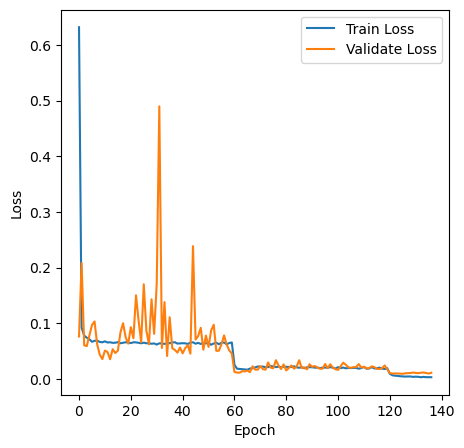

 68%|██████████████████████████████████████████████████▋                       | 137/200 [10:50:19<4:44:16, 270.74s/it]

Epoch:137
Time:10:54:36.238760
Loss:0.010747680531575913
Total:10000  Correct:9972  CleanAccuracy:0.9972


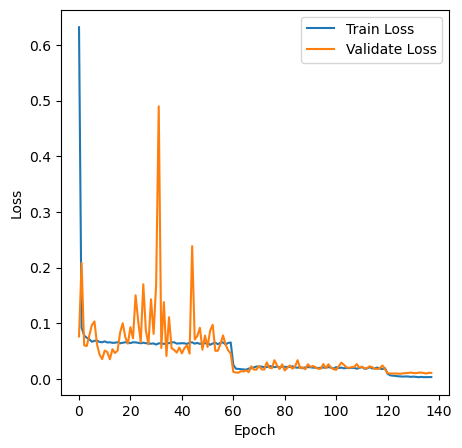

 69%|███████████████████████████████████████████████████                       | 138/200 [10:54:50<4:39:36, 270.59s/it]

Epoch:138
Time:10:59:06.941337
Loss:0.011688057563644045
Total:10000  Correct:9973  CleanAccuracy:0.9973


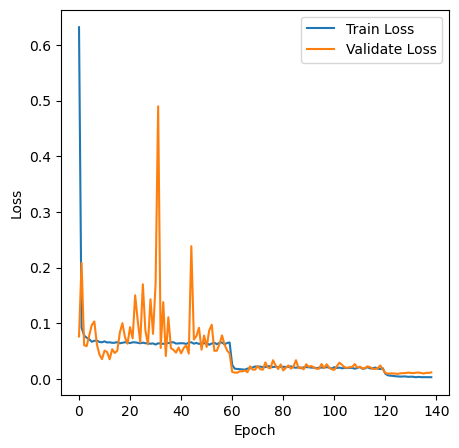

 70%|███████████████████████████████████████████████████▍                      | 139/200 [10:59:20<4:34:59, 270.49s/it]

Epoch:139
Time:11:03:37.858917
Loss:0.012028426925923985
Total:10000  Correct:9968  CleanAccuracy:0.9968


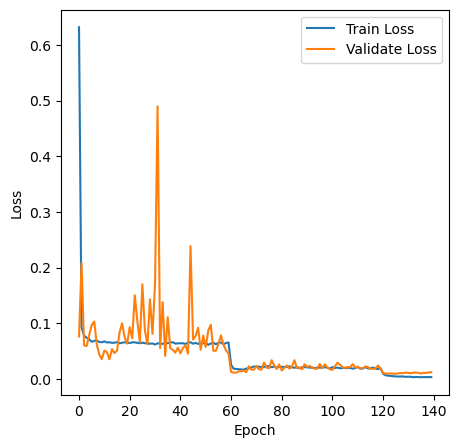

 70%|███████████████████████████████████████████████████▊                      | 140/200 [11:03:51<4:30:36, 270.61s/it]

Epoch:140
Time:11:08:06.376829
Loss:0.01271606385934735
Total:10000  Correct:9974  CleanAccuracy:0.9974


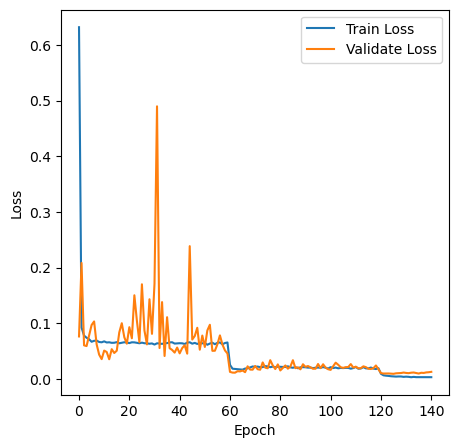

 70%|████████████████████████████████████████████████████▏                     | 141/200 [11:08:19<4:25:25, 269.92s/it]

Epoch:141
Time:11:12:27.415606
Loss:0.01197908845352241
Total:10000  Correct:9972  CleanAccuracy:0.9972


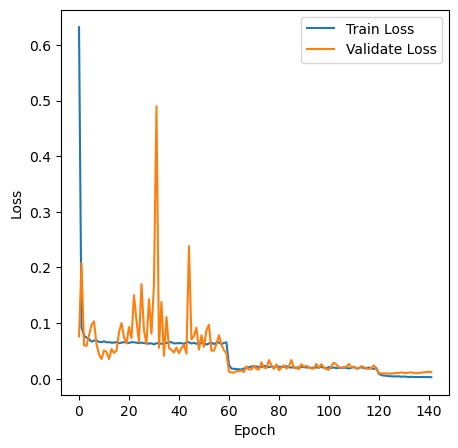

 71%|████████████████████████████████████████████████████▌                     | 142/200 [11:12:40<4:18:22, 267.28s/it]

Epoch:142
Time:11:16:51.519698
Loss:0.01186242878737193
Total:10000  Correct:9970  CleanAccuracy:0.9970


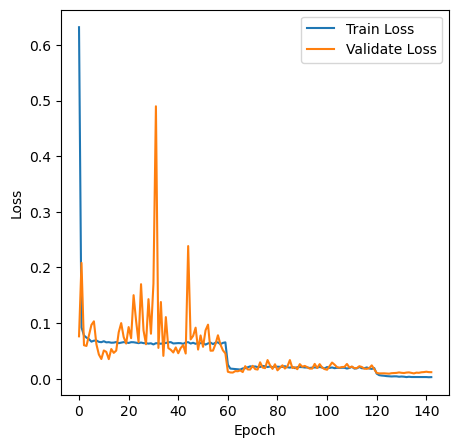

 72%|████████████████████████████████████████████████████▉                     | 143/200 [11:17:04<4:13:00, 266.33s/it]

Epoch:143
Time:11:21:23.783838
Loss:0.012158771287913943
Total:10000  Correct:9970  CleanAccuracy:0.9970


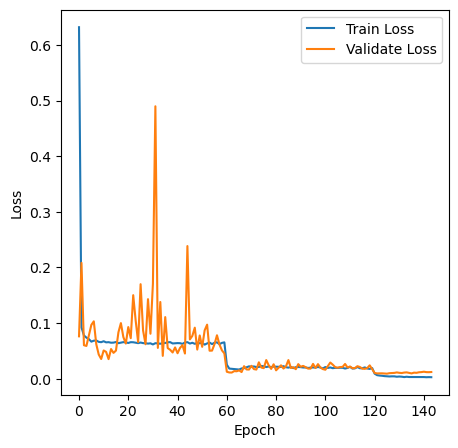

 72%|█████████████████████████████████████████████████████▎                    | 144/200 [11:21:37<4:10:22, 268.25s/it]

Epoch:144
Time:11:25:57.034702
Loss:0.011057890220969237
Total:10000  Correct:9976  CleanAccuracy:0.9976


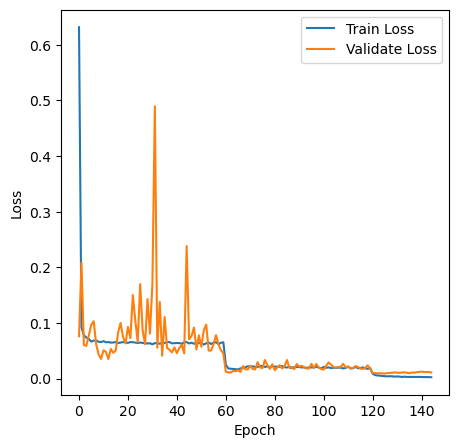

 72%|█████████████████████████████████████████████████████▋                    | 145/200 [11:26:10<4:07:17, 269.77s/it]

Epoch:145
Time:11:30:29.115351
Loss:0.012812014759652846
Total:10000  Correct:9966  CleanAccuracy:0.9966


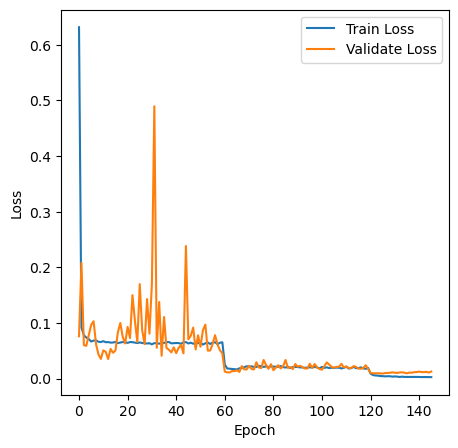

 73%|██████████████████████████████████████████████████████                    | 146/200 [11:30:42<4:03:18, 270.34s/it]

Epoch:146
Time:11:34:59.343797
Loss:0.011916120207091919
Total:10000  Correct:9975  CleanAccuracy:0.9975


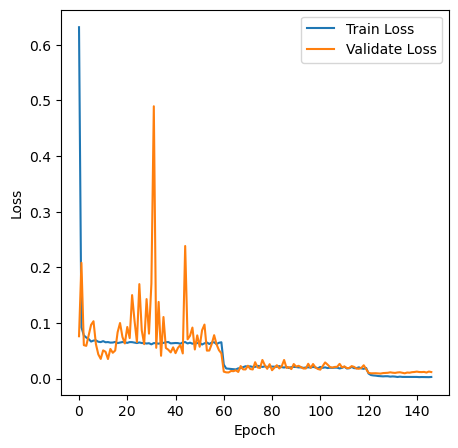

 74%|██████████████████████████████████████████████████████▍                   | 147/200 [11:35:12<3:58:47, 270.34s/it]

Epoch:147
Time:11:39:31.605537
Loss:0.013357240156126998
Total:10000  Correct:9968  CleanAccuracy:0.9968


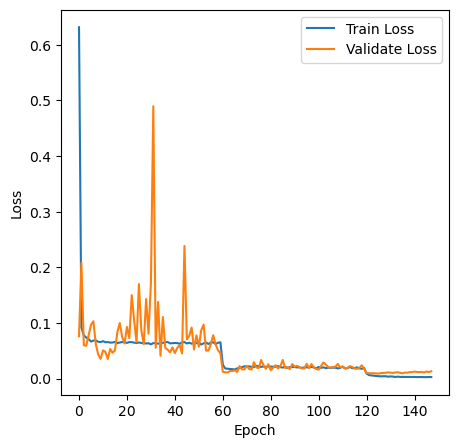

 74%|██████████████████████████████████████████████████████▊                   | 148/200 [11:39:45<3:54:51, 270.99s/it]

Epoch:148
Time:11:44:04.154485
Loss:0.011797733248037378
Total:10000  Correct:9974  CleanAccuracy:0.9974


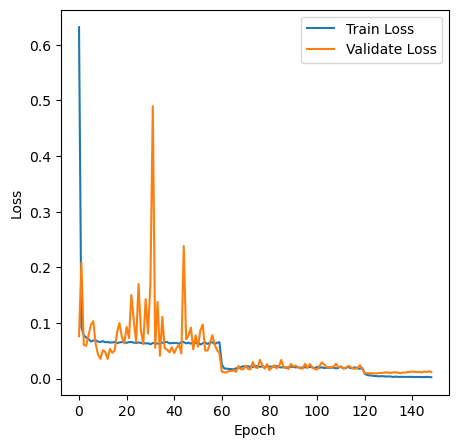

 74%|███████████████████████████████████████████████████████▏                  | 149/200 [11:44:17<3:50:40, 271.37s/it]

Epoch:149
Time:11:48:36.408605
Loss:0.011580893940949877
Total:10000  Correct:9973  CleanAccuracy:0.9973


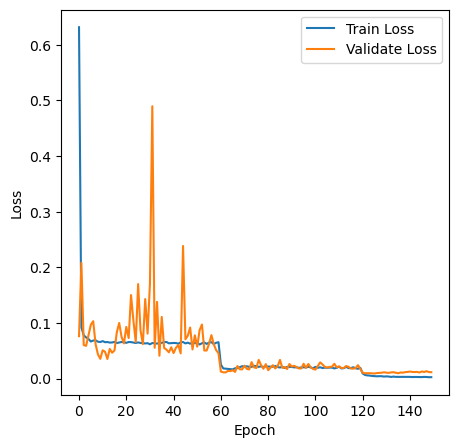

 75%|███████████████████████████████████████████████████████▌                  | 150/200 [11:48:50<3:46:24, 271.69s/it]

Epoch:150
Time:11:53:08.797218
Loss:0.011066737088609856
Total:10000  Correct:9974  CleanAccuracy:0.9974


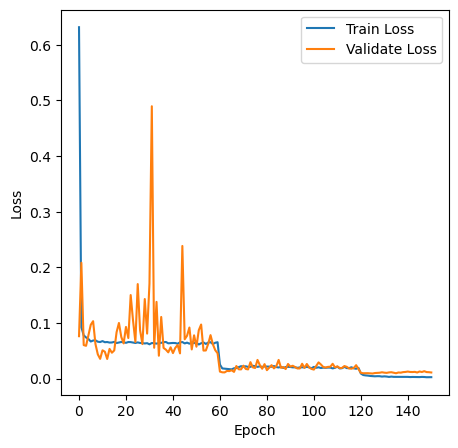

 76%|███████████████████████████████████████████████████████▊                  | 151/200 [11:53:22<3:42:01, 271.86s/it]

Epoch:151
Time:11:57:42.009252
Loss:0.01376976729632867
Total:10000  Correct:9969  CleanAccuracy:0.9969


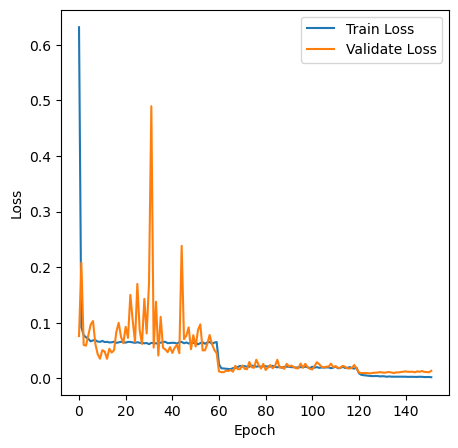

 76%|████████████████████████████████████████████████████████▏                 | 152/200 [11:57:55<3:37:50, 272.31s/it]

Epoch:152
Time:12:02:14.675116
Loss:0.013211029298497906
Total:10000  Correct:9969  CleanAccuracy:0.9969


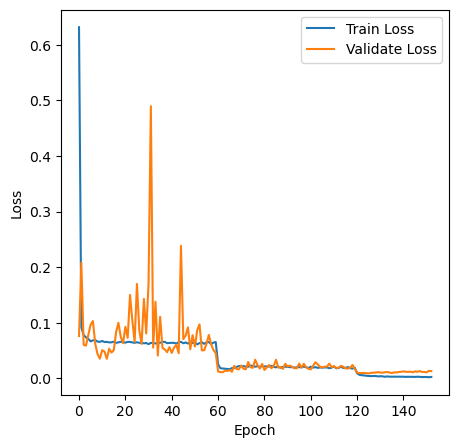

 76%|████████████████████████████████████████████████████████▌                 | 153/200 [12:02:28<3:33:26, 272.48s/it]

Epoch:153
Time:12:06:48.365336
Loss:0.01503574902226348
Total:10000  Correct:9963  CleanAccuracy:0.9963


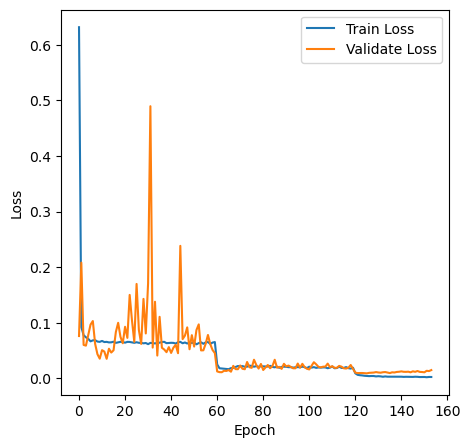

 77%|████████████████████████████████████████████████████████▉                 | 154/200 [12:07:02<3:29:08, 272.78s/it]

Epoch:154
Time:12:11:21.006609
Loss:0.01365148249004533
Total:10000  Correct:9966  CleanAccuracy:0.9966


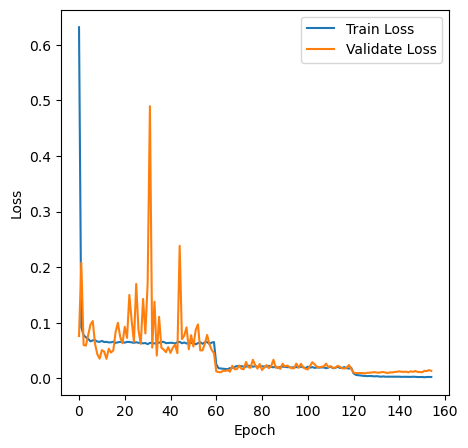

 78%|█████████████████████████████████████████████████████████▎                | 155/200 [12:11:34<3:24:30, 272.68s/it]

Epoch:155
Time:12:15:55.127387
Loss:0.01263690443448023
Total:10000  Correct:9971  CleanAccuracy:0.9971


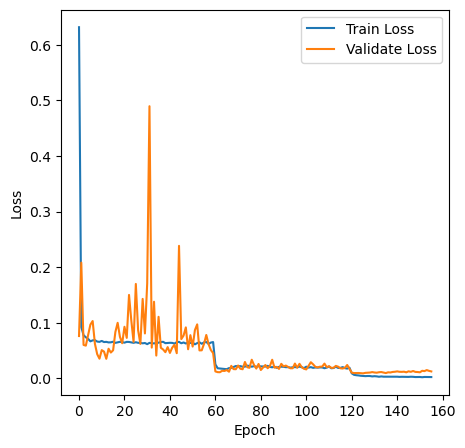

 78%|█████████████████████████████████████████████████████████▋                | 156/200 [12:16:08<3:20:15, 273.08s/it]

Epoch:156
Time:12:20:25.333235
Loss:0.014033101432318517
Total:10000  Correct:9961  CleanAccuracy:0.9961


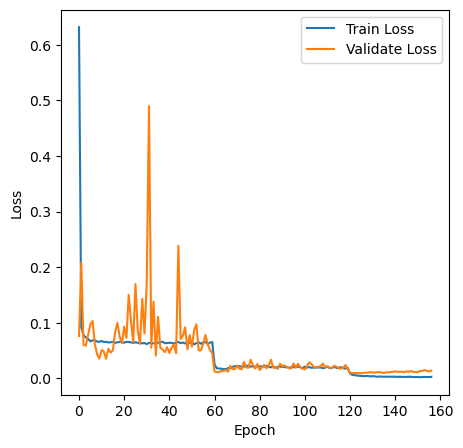

 78%|██████████████████████████████████████████████████████████                | 157/200 [12:20:39<3:15:11, 272.35s/it]

Epoch:157
Time:12:24:55.421838
Loss:0.0162936332953585
Total:10000  Correct:9961  CleanAccuracy:0.9961


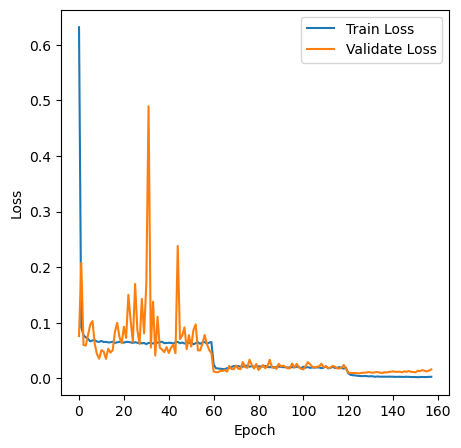

 79%|██████████████████████████████████████████████████████████▍               | 158/200 [12:25:08<3:10:06, 271.57s/it]

Epoch:158
Time:12:29:18.094508
Loss:0.013917076478681761
Total:10000  Correct:9967  CleanAccuracy:0.9967


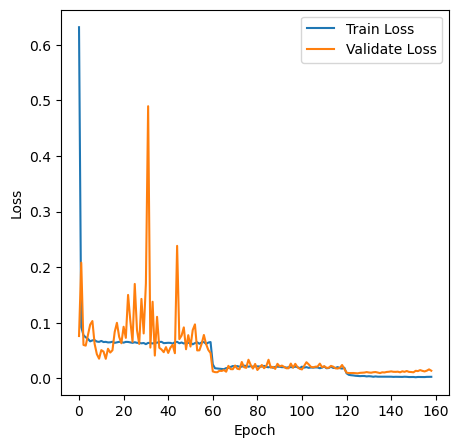

 80%|██████████████████████████████████████████████████████████▊               | 159/200 [12:29:31<3:03:41, 268.81s/it]

Epoch:159
Time:12:33:39.404164
Loss:0.012649166226753751
Total:10000  Correct:9967  CleanAccuracy:0.9967


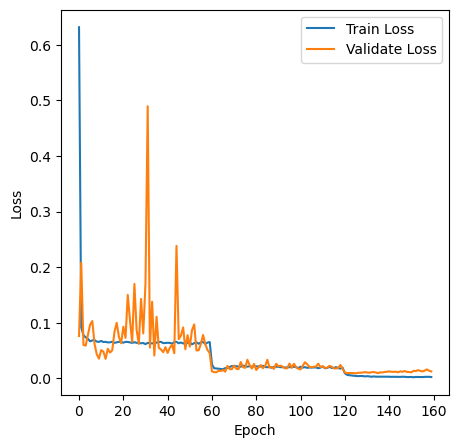

 80%|███████████████████████████████████████████████████████████▏              | 160/200 [12:33:52<2:57:43, 266.58s/it]

Epoch:160
Time:12:38:14.135874
Loss:0.014292042594482622
Total:10000  Correct:9962  CleanAccuracy:0.9962


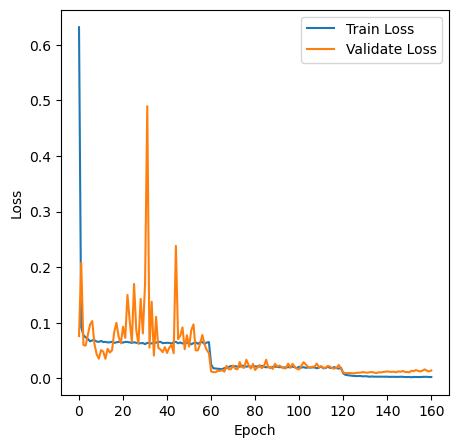

 80%|███████████████████████████████████████████████████████████▌              | 161/200 [12:38:29<2:55:15, 269.62s/it]

Epoch:161
Time:12:42:45.137172
Loss:0.011983501075502164
Total:10000  Correct:9971  CleanAccuracy:0.9971


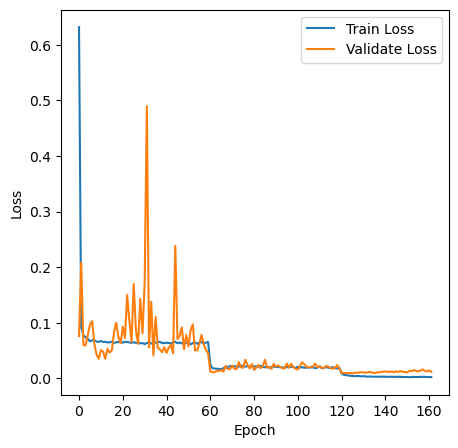

 81%|███████████████████████████████████████████████████████████▉              | 162/200 [12:42:58<2:50:34, 269.34s/it]

Epoch:162
Time:12:47:12.339795
Loss:0.011865019979875553
Total:10000  Correct:9969  CleanAccuracy:0.9969


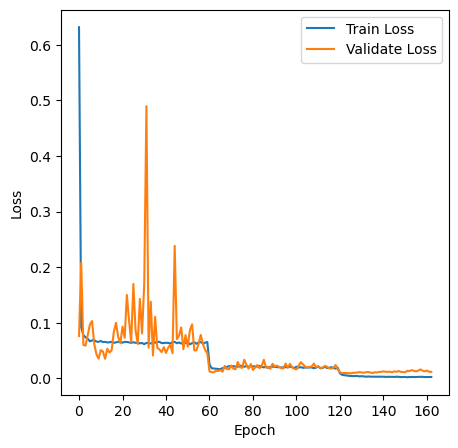

 82%|████████████████████████████████████████████████████████████▎             | 163/200 [12:47:25<2:45:49, 268.90s/it]

Epoch:163
Time:12:51:36.899159
Loss:0.012315830922207257
Total:10000  Correct:9964  CleanAccuracy:0.9964


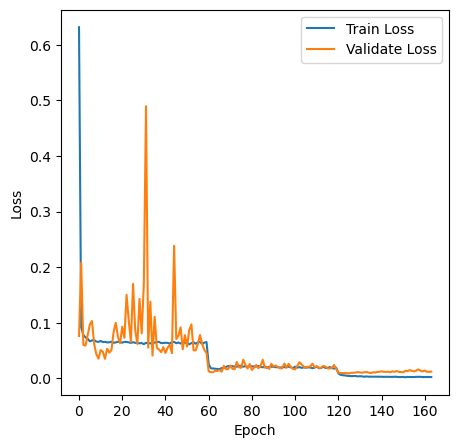

 82%|████████████████████████████████████████████████████████████▋             | 164/200 [12:51:50<2:40:33, 267.60s/it]

Epoch:164
Time:12:55:57.322007
Loss:0.013634228185875515
Total:10000  Correct:9963  CleanAccuracy:0.9963


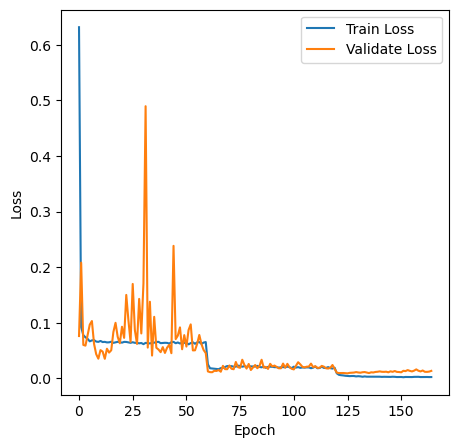

 82%|█████████████████████████████████████████████████████████████             | 165/200 [12:56:10<2:34:46, 265.32s/it]

Epoch:165
Time:13:00:18.887576
Loss:0.01338179185264967
Total:10000  Correct:9973  CleanAccuracy:0.9973


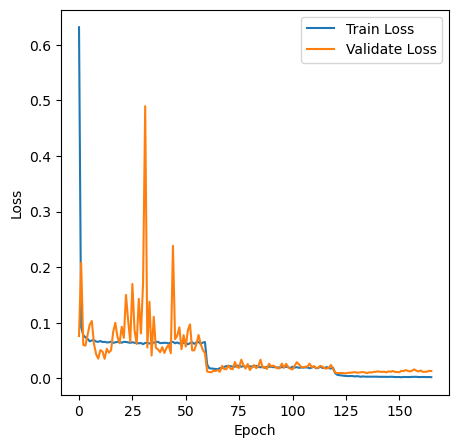

 83%|█████████████████████████████████████████████████████████████▍            | 166/200 [13:00:31<2:29:41, 264.16s/it]

Epoch:166
Time:13:04:52.400263
Loss:0.012327746387173872
Total:10000  Correct:9966  CleanAccuracy:0.9966


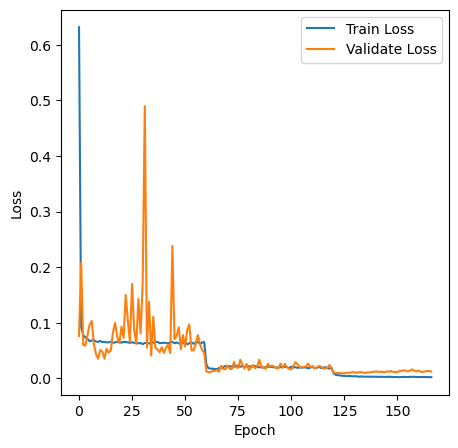

 84%|█████████████████████████████████████████████████████████████▊            | 167/200 [13:05:07<2:27:08, 267.55s/it]

Epoch:167
Time:13:09:51.148214
Loss:0.015563151501967146
Total:10000  Correct:9967  CleanAccuracy:0.9967


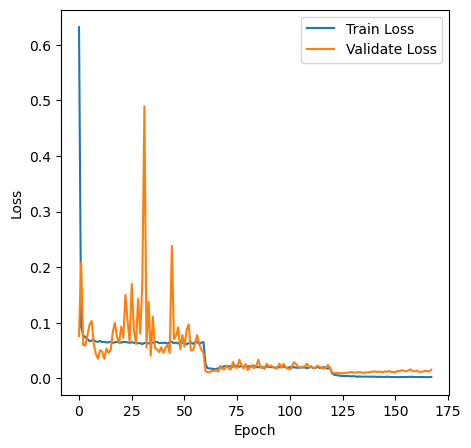

 84%|██████████████████████████████████████████████████████████████▏           | 168/200 [13:10:06<2:27:44, 277.03s/it]

Epoch:168
Time:13:14:57.611026
Loss:0.01615491680136641
Total:10000  Correct:9962  CleanAccuracy:0.9962


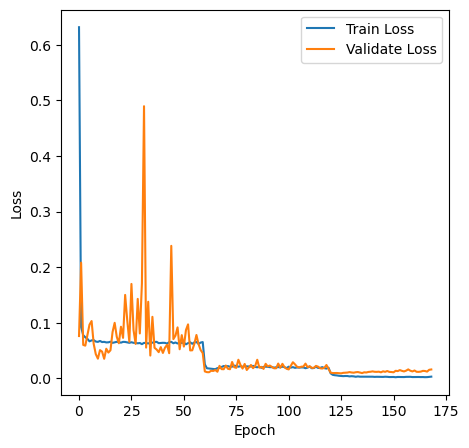

 84%|██████████████████████████████████████████████████████████████▌           | 169/200 [13:15:12<2:27:41, 285.84s/it]

Epoch:169
Time:13:19:44.997523
Loss:0.01342740824063734
Total:10000  Correct:9968  CleanAccuracy:0.9968


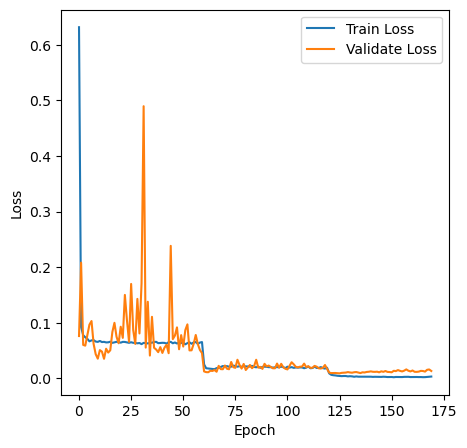

 85%|██████████████████████████████████████████████████████████████▉           | 170/200 [13:19:59<2:23:04, 286.16s/it]

Epoch:170
Time:13:24:38.673165
Loss:0.013589983043363526
Total:10000  Correct:9967  CleanAccuracy:0.9967


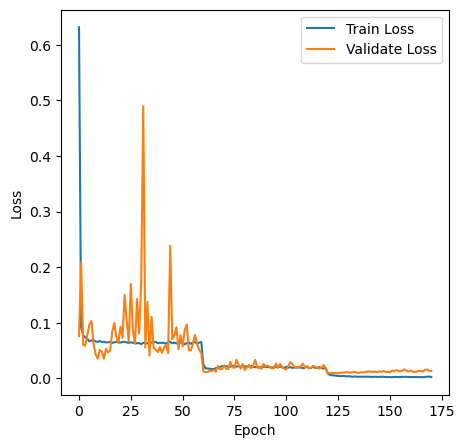

 86%|███████████████████████████████████████████████████████████████▎          | 171/200 [13:24:52<2:19:13, 288.06s/it]

Epoch:171
Time:13:29:08.888615
Loss:0.013681219218815037
Total:10000  Correct:9966  CleanAccuracy:0.9966


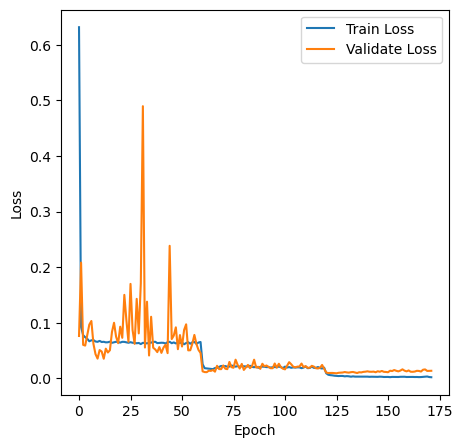

 86%|███████████████████████████████████████████████████████████████▋          | 172/200 [13:29:23<2:12:03, 282.99s/it]

Epoch:172
Time:13:34:05.360484
Loss:0.01371489057504087
Total:10000  Correct:9967  CleanAccuracy:0.9967


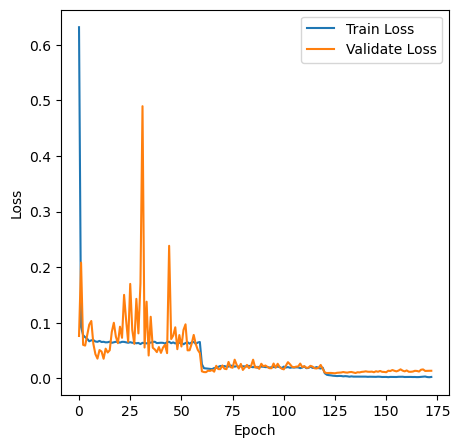

 86%|████████████████████████████████████████████████████████████████          | 173/200 [13:34:19<2:09:09, 287.02s/it]

Epoch:173
Time:13:38:44.000974
Loss:0.014936879153375309
Total:10000  Correct:9963  CleanAccuracy:0.9963


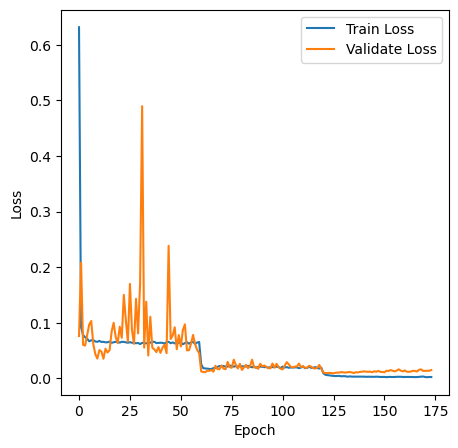

 87%|████████████████████████████████████████████████████████████████▍         | 174/200 [13:38:57<2:03:09, 284.19s/it]

Epoch:174
Time:13:43:42.305937
Loss:0.013741712890953694
Total:10000  Correct:9970  CleanAccuracy:0.9970


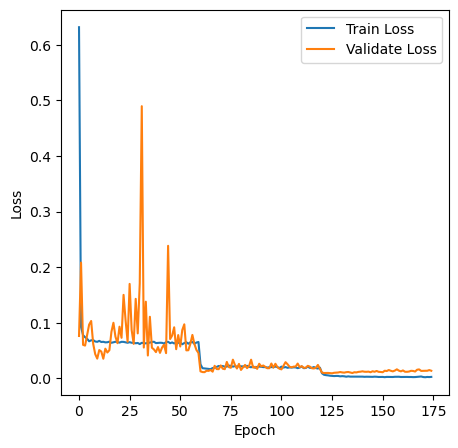

 88%|████████████████████████████████████████████████████████████████▊         | 175/200 [13:43:55<2:00:07, 288.29s/it]

Epoch:175
Time:13:48:12.553006
Loss:0.01338800364516128
Total:10000  Correct:9972  CleanAccuracy:0.9972


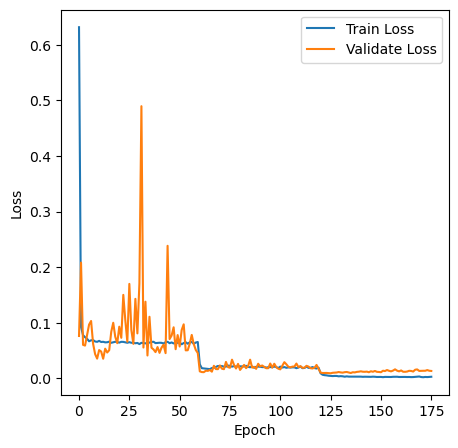

 88%|█████████████████████████████████████████████████████████████████         | 176/200 [13:48:25<1:53:10, 282.95s/it]

Epoch:176
Time:13:53:13.717980
Loss:0.015516470085525255
Total:10000  Correct:9962  CleanAccuracy:0.9962


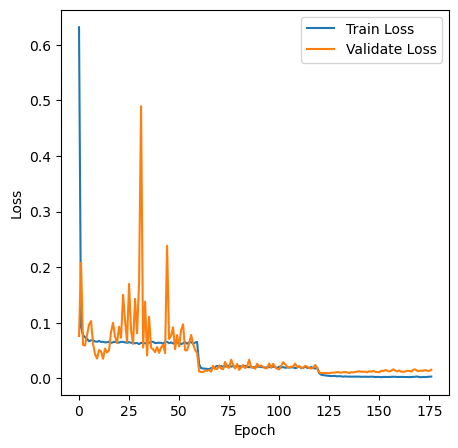

 88%|█████████████████████████████████████████████████████████████████▍        | 177/200 [13:53:27<1:50:35, 288.50s/it]

Epoch:177
Time:13:57:48.017324
Loss:0.015844838162616323
Total:10000  Correct:9960  CleanAccuracy:0.9960


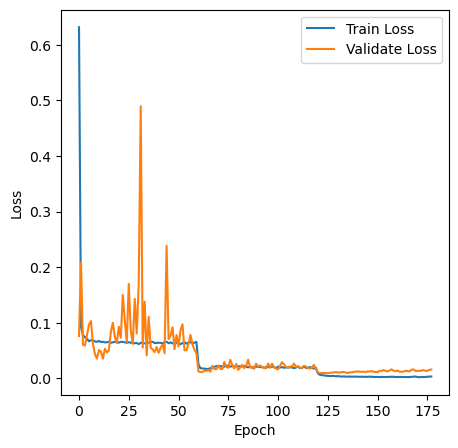

 89%|█████████████████████████████████████████████████████████████████▊        | 178/200 [13:58:02<1:44:17, 284.42s/it]

Epoch:178
Time:14:02:46.699877
Loss:0.018223562809719016
Total:10000  Correct:9952  CleanAccuracy:0.9952


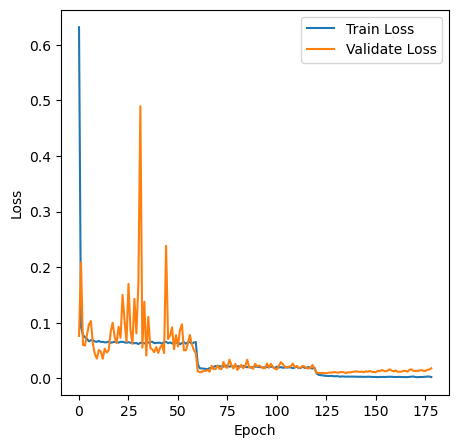

 90%|██████████████████████████████████████████████████████████████████▏       | 179/200 [14:03:00<1:41:00, 288.61s/it]

Epoch:179
Time:14:07:05.980733
Loss:0.013941447143056118
Total:10000  Correct:9963  CleanAccuracy:0.9963


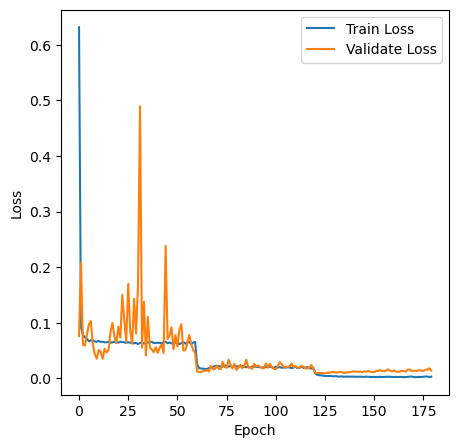

 90%|██████████████████████████████████████████████████████████████████▌       | 180/200 [14:07:20<1:33:17, 279.88s/it]

Epoch:180
Time:14:12:18.654192
Loss:0.013733790599935935
Total:10000  Correct:9964  CleanAccuracy:0.9964


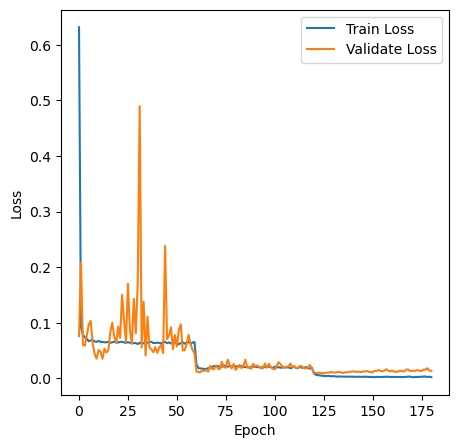

 90%|██████████████████████████████████████████████████████████████████▉       | 181/200 [14:12:33<1:31:49, 289.99s/it]

Epoch:181
Time:14:17:21.008601
Loss:0.013488975586555601
Total:10000  Correct:9966  CleanAccuracy:0.9966


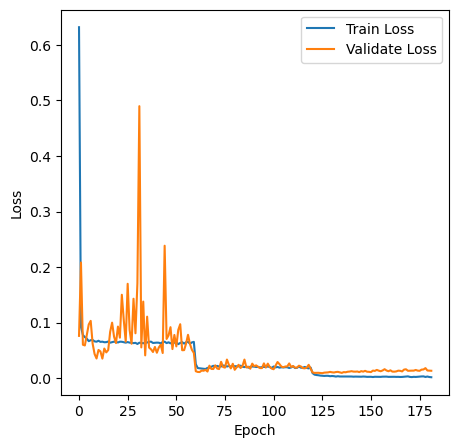

 91%|███████████████████████████████████████████████████████████████████▎      | 182/200 [14:17:34<1:27:56, 293.15s/it]

Epoch:182
Time:14:22:04.581271
Loss:0.013474962959354655
Total:10000  Correct:9965  CleanAccuracy:0.9965


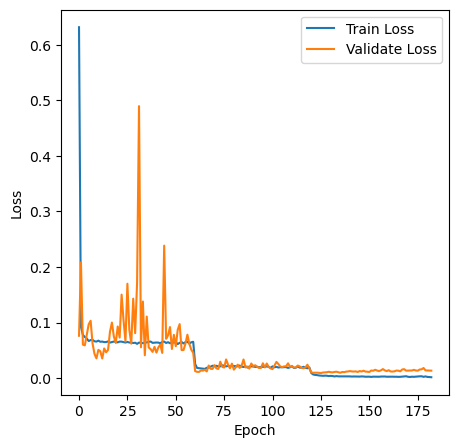

 92%|███████████████████████████████████████████████████████████████████▋      | 183/200 [14:22:17<1:22:12, 290.12s/it]

Epoch:183
Time:14:26:44.969789
Loss:0.01392195433831607
Total:10000  Correct:9964  CleanAccuracy:0.9964


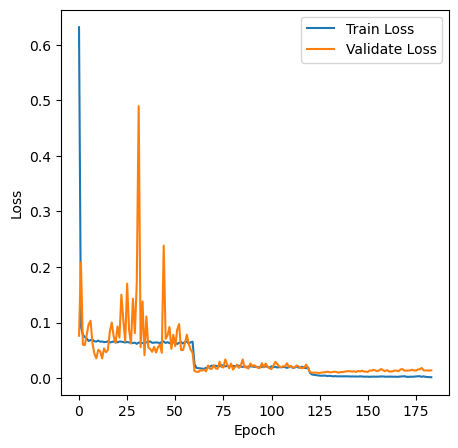

 92%|████████████████████████████████████████████████████████████████████      | 184/200 [14:26:59<1:16:45, 287.83s/it]

Epoch:184
Time:14:31:55.364844
Loss:0.014158655177264775
Total:10000  Correct:9966  CleanAccuracy:0.9966


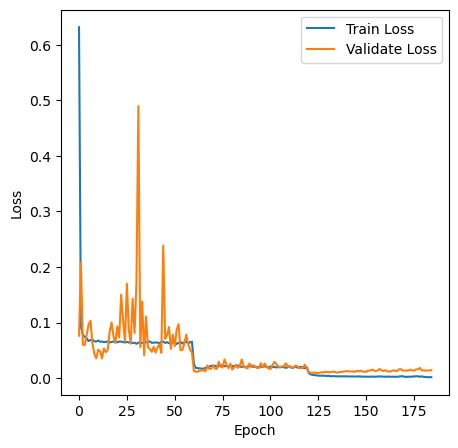

 92%|████████████████████████████████████████████████████████████████████▍     | 185/200 [14:32:10<1:13:41, 294.75s/it]

Epoch:185
Time:14:37:09.939324
Loss:0.01365094111593345
Total:10000  Correct:9964  CleanAccuracy:0.9964


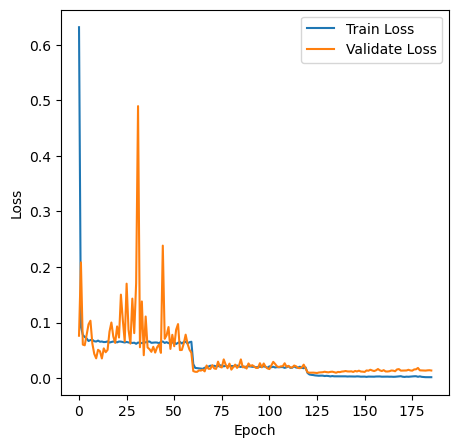

 93%|████████████████████████████████████████████████████████████████████▊     | 186/200 [14:37:24<1:10:08, 300.59s/it]

Epoch:186
Time:14:42:00.139673
Loss:0.013849613448298468
Total:10000  Correct:9967  CleanAccuracy:0.9967


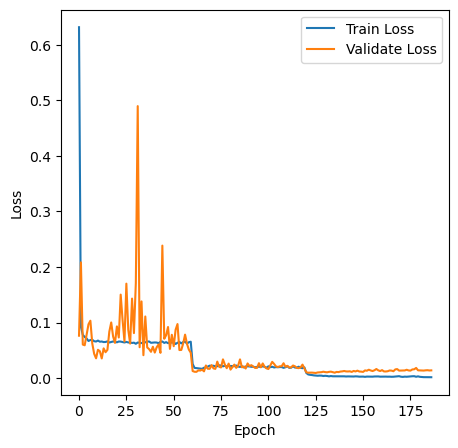

 94%|█████████████████████████████████████████████████████████████████████▏    | 187/200 [14:42:14<1:04:23, 297.20s/it]

Epoch:187
Time:14:46:58.588316
Loss:0.014357906576642505
Total:10000  Correct:9964  CleanAccuracy:0.9964


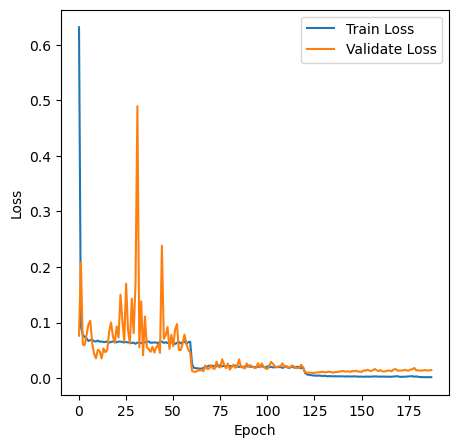

 94%|███████████████████████████████████████████████████████████████████████▍    | 188/200 [14:47:13<59:33, 297.82s/it]

Epoch:188
Time:14:52:09.914156
Loss:0.013473779864563865
Total:10000  Correct:9967  CleanAccuracy:0.9967


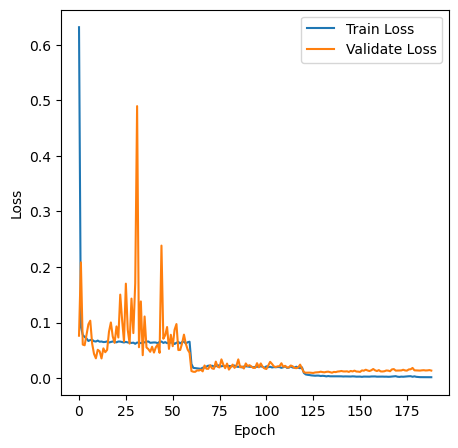

 94%|███████████████████████████████████████████████████████████████████████▊    | 189/200 [14:52:24<55:20, 301.88s/it]

Epoch:189
Time:14:57:09.956548
Loss:0.013608250686096938
Total:10000  Correct:9966  CleanAccuracy:0.9966


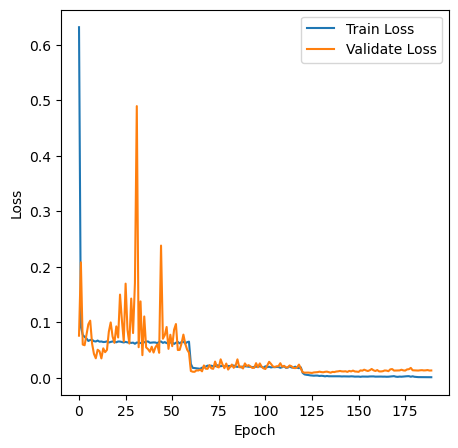

 95%|████████████████████████████████████████████████████████████████████████▏   | 190/200 [14:57:24<50:12, 301.25s/it]

Epoch:190
Time:15:02:05.989512
Loss:0.013461052578094358
Total:10000  Correct:9967  CleanAccuracy:0.9967


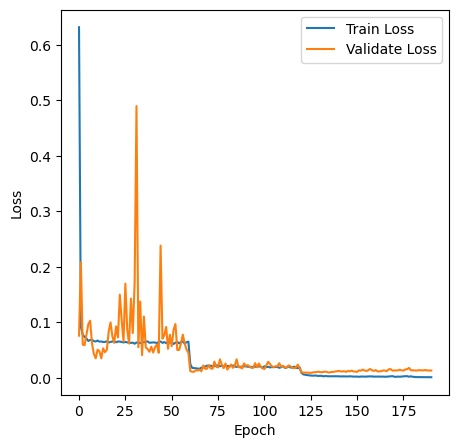

 96%|████████████████████████████████████████████████████████████████████████▌   | 191/200 [15:02:19<44:54, 299.39s/it]

Epoch:191
Time:15:06:33.890851
Loss:0.013216131332664402
Total:10000  Correct:9971  CleanAccuracy:0.9971


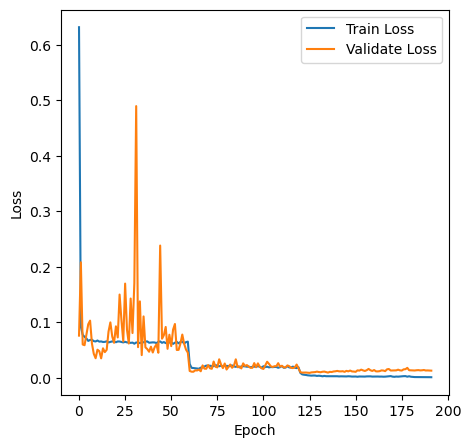

 96%|████████████████████████████████████████████████████████████████████████▉   | 192/200 [15:06:48<38:42, 290.34s/it]

Epoch:192
Time:15:11:48.242763
Loss:0.013135892950045242
Total:10000  Correct:9968  CleanAccuracy:0.9968


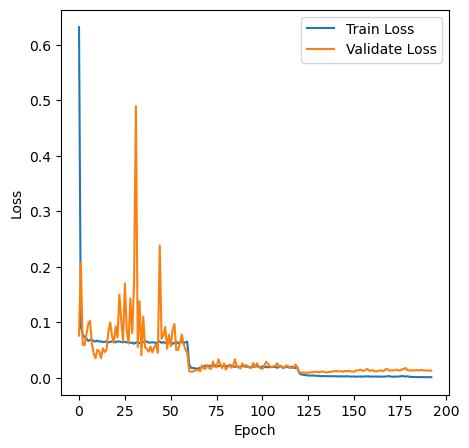

 96%|█████████████████████████████████████████████████████████████████████████▎  | 193/200 [15:12:03<34:44, 297.72s/it]

Epoch:193
Time:15:17:05.775907
Loss:0.013334484441360584
Total:10000  Correct:9968  CleanAccuracy:0.9968


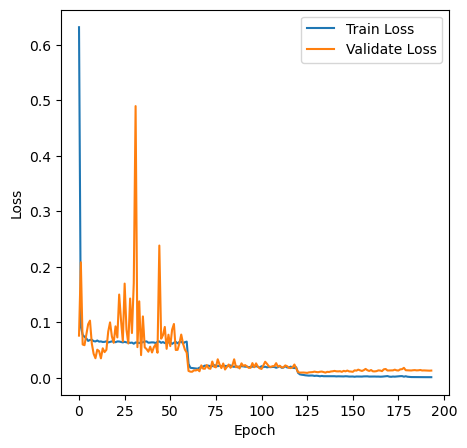

 97%|█████████████████████████████████████████████████████████████████████████▋  | 194/200 [15:17:21<30:21, 303.58s/it]

Epoch:194
Time:15:22:23.239476
Loss:0.014052123842539992
Total:10000  Correct:9966  CleanAccuracy:0.9966


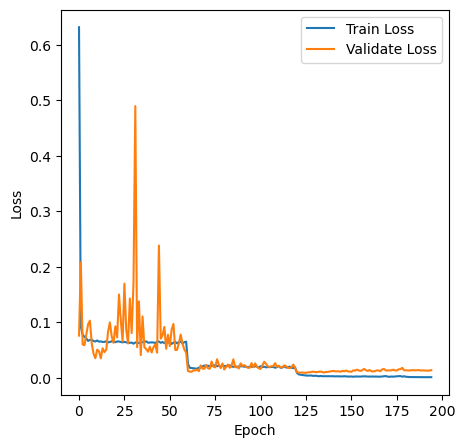

 98%|██████████████████████████████████████████████████████████████████████████  | 195/200 [15:22:38<25:38, 307.61s/it]

Epoch:195
Time:15:26:48.961550
Loss:0.014029269221241767
Total:10000  Correct:9968  CleanAccuracy:0.9968


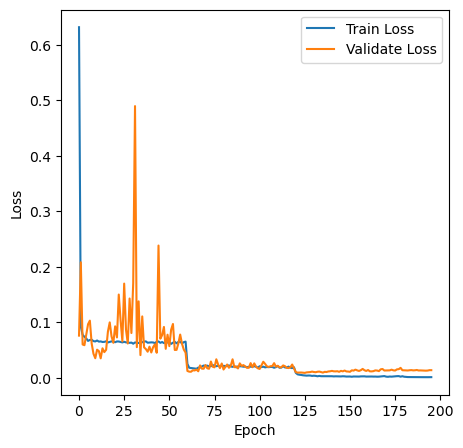

 98%|██████████████████████████████████████████████████████████████████████████▍ | 196/200 [15:27:02<19:38, 294.74s/it]

Epoch:196
Time:15:31:29.251055
Loss:0.013987364241676317
Total:10000  Correct:9967  CleanAccuracy:0.9967


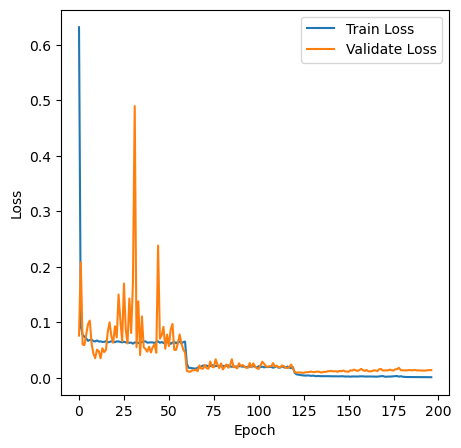

 98%|██████████████████████████████████████████████████████████████████████████▊ | 197/200 [15:31:43<14:31, 290.61s/it]

Epoch:197
Time:15:36:12.194257
Loss:0.01358338528738235
Total:10000  Correct:9967  CleanAccuracy:0.9967


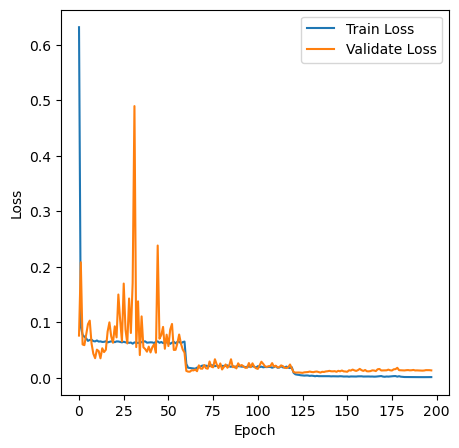

 99%|███████████████████████████████████████████████████████████████████████████▏| 198/200 [15:36:26<09:36, 288.24s/it]

Epoch:198
Time:15:40:37.413239
Loss:0.013605060174870795
Total:10000  Correct:9967  CleanAccuracy:0.9967


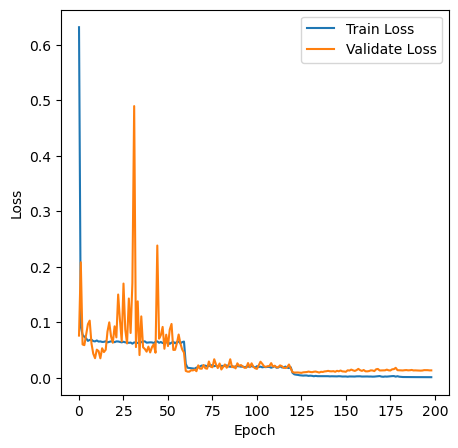

100%|███████████████████████████████████████████████████████████████████████████▌| 199/200 [15:40:51<04:41, 281.21s/it]

Epoch:199
Time:15:45:26.182077
Loss:0.013417213350704041
Total:10000  Correct:9968  CleanAccuracy:0.9968


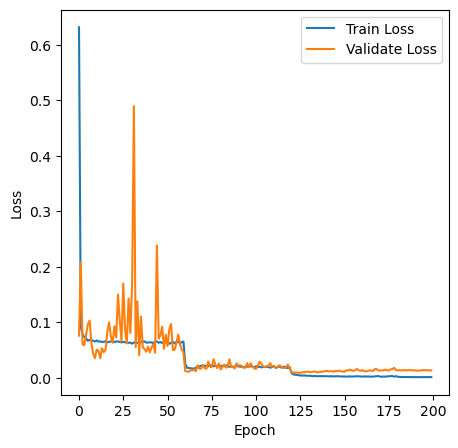

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [15:45:40<00:00, 283.70s/it]


In [9]:
train(model_device=device,
      model=net,
      model_optimizer=optimizer, 
      train_set=train_loader, 
      validate_set=test_loader
)

In [10]:
torch.cuda.empty_cache()